# Demo of the BGTM on 2-Dimensional Joe-Copula

In this demonstration we show how the GTM can be used to learn a probability distribution from synthetic data sampled from a 2 dimensional Joe copula.
To sample synthetic copula data we use the [pyvinecopulib](https://github.com/vinecopulib/pyvinecopulib) library.
Fore more details on copulas we refer to the Book [Analyzing Dependent Data with Vine Copulas](https://link.springer.com/book/10.1007/978-3-030-13785-4) for an comprehensive introduction to copulas and vine copulas.

In [1]:
from pathlib import Path
import sys

# Add project root (parent of "demos") to sys.path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))


from gtm import *

# Sample Copulas Package
import pyvinecopulib as pv

# Other Stuff
import numpy as np
import torch
from torch.utils.data import DataLoader
from demos.dataset_helpers import Generic_Dataset

/Users/franciscocapunay/miniforge3/envs/gtm-magic-env-3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 1. Sample Synthetic Copula Data and Compute Likelihoods

We sample data from a Joe Copula and add Gaussian marginals. Feel free to exchange the copula parameter, the rotation or even the copula itsself.
The list of copulas can be found with `help(pv.Bicop)`.

Notice we use Sklars Theorem to compute the density of the joint copula and Gaussian marginals density.

In [2]:
copula_pv = pv.Bicop(family=pv.BicopFamily.joe, parameters=np.array([[2.5]]), rotation=90)

# Train
N_train = 2000
simulated_data_uniform_train = copula_pv.simulate(n=N_train)
simulated_data_train = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_train)).float()

# Validate
N_validate = 2000
simulated_data_uniform_validate = copula_pv.simulate(n=N_validate)
simulated_data_validate = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_validate)).float()

# Test
N_test = 20000
simulated_data_uniform_test = copula_pv.simulate(n=N_test)
simulated_data_test = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_test)).float()

In [3]:
loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_train))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_train)).sum(1)
loglik_true_train = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_validate))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_validate)).sum(1)
loglik_true_validate = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_test))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_test)).sum(1)
loglik_true_test = torch.tensor(loglik_copula) + log_marginals

/var/folders/_p/ttn2qcdj23jdpltyffhwq9pr0000gn/T/ipykernel_84211/2085715786.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_train)).sum(1)
/var/folders/_p/ttn2qcdj23jdpltyffhwq9pr0000gn/T/ipykernel_84211/2085715786.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_validate)).sum(1)
/var/folders/_p/ttn2qcdj23jdpltyffhwq9pr0000gn/T/ipykernel_84211/2085715786.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True)

We further estimate the copula on the synthetic data to get an oracle denisity estimator. Hence an estimator that knows the true underlying structure and merely estiamtes the model parameters.

In [4]:
copula_pv_est = pv.Bicop(family=pv.BicopFamily.joe, rotation=90)
copula_pv_est.fit(simulated_data_uniform_train)
means = simulated_data_train.mean(0)
vars = simulated_data_train.var(0)

In [5]:
loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_train))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_train).sum(1)
loglik_true_est_train = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_validate))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_validate).sum(1)
loglik_true_est_validate = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_test))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_test).sum(1)
loglik_true_est_test = torch.tensor(loglik_copula) + log_marginals

The package is implemented to use Dataloaders for training. This is done to accommodate larger datasets trained batch wise as is common in deep learning and bioinformatics applications. Feel free to use the [`Generic_Dataset`](demos/dataset_helpers.py) class to easily adjust it to your data. For full data training, thus whithout batches simply seet the `batch_size` arguement in the `DataLoader` to the data size as we do in this example

In [6]:
# Create dataset and DataLoader
dataset_train = Generic_Dataset(simulated_data_train)
dataloader_train = DataLoader(dataset_train, batch_size=N_train)

dataset_validate = Generic_Dataset(simulated_data_validate)
dataloader_validate = DataLoader(dataset_validate, batch_size=N_validate)

### 2. Define Model

We define a simple GTM model with the standard parameters.
Notable custamizable parameter are: 
- The dimensionality of the data `number_variables`
- The number of transformation layers `num_trans_layers`, either 0 or 1.
- The number of decorrelation layers `num_decorr_layers`, typically 3 or more. 
- the spline to use for the transformation layer splines `spline_transformation` and the decorrelation layer splines `spline_decorrelation`.  The two types of layers: P-Splines (`bspline`) or bernstein polynomials (`bernstein`).
- The degrees of the splines, representing there flexibility, being `degree_decorrelation` for the decorrelation layer splines and `degree_transformations` for the transformation layer. When using `bspline`, then `degree_transformations` can also be given a list with varying degrees for each dimension of the data.
- `transformation_spline_range`sets the outer borders for the transformation layer splines, this dependends on the input data and should be set a bit wider then the actual data.
- `device` either `cpu`or `cuda`


In [7]:
hyperparameters = {
    "transformation": {
    "sigma_a": 2.0, "sigma_b": 10.0,        #Ignored not used
    "RW2": { "tau_a": 2.0, "tau_b": 1.0 }, #lambda  E[λ]=2
    "RW1": { "tau_a": 10.0,"tau_b": 15.0 }  #Ignored not used
    },
    "decorrelation": {
    "sigma_a": 2, "sigma_b": 10,        # mean σ² = 10 (weak)
    "RW2": {"tau_a": 2.0, "tau_b": 2.0},  # E[λ2]=1       (start)
    "RW1": {"tau_a": 1.0, "tau_b": 1.0}   # E[λ1]=1
    }
}



model = GTM(
    number_variables=2,
    number_transformation_layers=1,
    number_decorrelation_layers=3,
    degree_transformations=10,
    degree_decorrelation=40,
    spline_transformation="bspline",
    spline_decorrelation="bspline",
    transformation_spline_range=(-10, 10),
    device="cpu",
    ## NEW ARGUMENTS ##
    inference = 'bayesian',
    hyperparameter=hyperparameters
    )


device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
_=model

The GTM class contains a number of plotting functions so that standard analysis can be done soley with the model:

In [8]:
#model.plot_marginals(simulated_data_train)

### 3. Hyperparameter Tune and Train Model

To find the optimal penalties one uses the `hyperparameter_tune_penalties` function. Then using the optimal penalties one can train the model.

The training can be done by pretraining the marginal transformations with `pretrain_tranformation_layer` and then training jointly with `train`.
In general empirically we found that pretraining reduces training time and improves results allthough direct joint training also works.

Hyperparameter tuning can be done for the penalties `penvalueridge, penfirstridge , pensecondridge, ctm_pensecondridge, lambda_penalty_params` by passing the arguement `"sample"`.
If a fixed number is passed, typically zero, then for that penalty no hyperparameter drawing is done and the fixed values is used.


In [9]:
output = model.fit_bayes(
                train_dataloader=dataloader_train,
                validate_dataloader=dataloader_validate,
                hyperparameters=None,
                iterations=1000,
                verbose=True,
                lr=0.01,
                mcmc_sample_train=4,            # will ramp
                mcmc_sample_val=16,             # fixed & larger for stable eval
                mc_ramp_every=25,               # 4→8→16→32 at epochs 25/50/75
                mc_ramp_max=32,
                patience_val=15,                # early-stop patience
                min_delta=0.001,                # ~0.1% absolute of your loss scale
                rho_lr_multiplier=1.5,          # slightly faster variance adaption (optional)
                sched_factor=0.5, sched_patience=6, sched_threshold=1e-4,
            )

/Users/franciscocapunay/miniforge3/envs/gtm-magic-env-3.11/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
  0%|          | 0/1000 [00:00<?, ?it/s]/Users/franciscocapunay/Documents/AkademischeAusbildungLernunterlagen/UniversitaetGoettingen/Studiengänge/MasterAngewandteStatistik/4.Semester/MA/code/gtm/gtm/gtm_splines/bspline_prediction_vectorized.py:595: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3641.)
  x=input_a_clone.T, t=knots.T, c=params_a.

[1/1000] train=235.4076  val=236.8117  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0507  σmin=0.0507  σmax=0.0507


  0%|          | 2/1000 [00:00<05:09,  3.22it/s]

[2/1000] train=228.9709  val=234.6104  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0515  σmin=0.0515  σmax=0.0515


  0%|          | 3/1000 [00:00<05:11,  3.20it/s]

[3/1000] train=227.0622  val=232.4104  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0522  σmin=0.0522  σmax=0.0522


  0%|          | 4/1000 [00:01<05:30,  3.01it/s]

[4/1000] train=223.5294  val=230.2117  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0530  σmin=0.0530  σmax=0.0530


  0%|          | 5/1000 [00:01<06:12,  2.67it/s]

[5/1000] train=222.9276  val=228.0144  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0538  σmin=0.0538  σmax=0.0538


  1%|          | 6/1000 [00:02<06:31,  2.54it/s]

[6/1000] train=230.8993  val=225.8180  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0546  σmin=0.0546  σmax=0.0546


  1%|          | 7/1000 [00:02<06:22,  2.60it/s]

[7/1000] train=217.7452  val=223.6224  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0554  σmin=0.0554  σmax=0.0554


  1%|          | 8/1000 [00:02<05:50,  2.83it/s]

[8/1000] train=220.4500  val=221.4285  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0562  σmin=0.0562  σmax=0.0562


  1%|          | 9/1000 [00:03<05:27,  3.03it/s]

[9/1000] train=216.8625  val=219.2363  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0570  σmin=0.0570  σmax=0.0570


  1%|          | 10/1000 [00:03<05:23,  3.06it/s]

[10/1000] train=215.3554  val=217.0453  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0579  σmin=0.0579  σmax=0.0579


  1%|          | 11/1000 [00:03<05:19,  3.10it/s]

[11/1000] train=219.0591  val=214.8549  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0587  σmin=0.0587  σmax=0.0587


  1%|          | 12/1000 [00:04<05:03,  3.25it/s]

[12/1000] train=216.3691  val=212.6657  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0596  σmin=0.0596  σmax=0.0596


  1%|▏         | 13/1000 [00:04<05:17,  3.10it/s]

[13/1000] train=217.2461  val=210.4776  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0604  σmin=0.0604  σmax=0.0604


  1%|▏         | 14/1000 [00:04<05:03,  3.25it/s]

[14/1000] train=220.5346  val=208.2898  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0613  σmin=0.0613  σmax=0.0613


  2%|▏         | 15/1000 [00:04<04:53,  3.36it/s]

[15/1000] train=207.6877  val=206.1037  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0622  σmin=0.0622  σmax=0.0622


  2%|▏         | 16/1000 [00:05<04:44,  3.46it/s]

[16/1000] train=207.4616  val=203.9189  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0631  σmin=0.0631  σmax=0.0631


  2%|▏         | 17/1000 [00:05<04:38,  3.53it/s]

[17/1000] train=200.5239  val=201.7354  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0641  σmin=0.0641  σmax=0.0641


  2%|▏         | 18/1000 [00:05<04:34,  3.58it/s]

[18/1000] train=203.9162  val=199.5534  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0650  σmin=0.0650  σmax=0.0650


  2%|▏         | 19/1000 [00:06<04:32,  3.61it/s]

[19/1000] train=195.0685  val=197.3723  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0660  σmin=0.0660  σmax=0.0660


  2%|▏         | 20/1000 [00:06<04:31,  3.61it/s]

[20/1000] train=201.3580  val=195.1925  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0669  σmin=0.0669  σmax=0.0669


  2%|▏         | 21/1000 [00:06<04:32,  3.59it/s]

[21/1000] train=188.1543  val=193.0138  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0679  σmin=0.0679  σmax=0.0679


  2%|▏         | 22/1000 [00:06<04:30,  3.62it/s]

[22/1000] train=193.8408  val=190.8365  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0689  σmin=0.0689  σmax=0.0689


  2%|▏         | 23/1000 [00:07<04:29,  3.62it/s]

[23/1000] train=184.2841  val=188.6607  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0699  σmin=0.0699  σmax=0.0699


  2%|▏         | 24/1000 [00:07<04:55,  3.30it/s]

[24/1000] train=193.3582  val=186.4866  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0709  σmin=0.0709  σmax=0.0709


  2%|▎         | 25/1000 [00:07<05:10,  3.14it/s]

[25/1000] train=184.2263  val=184.3135  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0719  σmin=0.0719  σmax=0.0720


  3%|▎         | 26/1000 [00:08<05:51,  2.77it/s]

[26/1000] train=180.6108  val=182.1410  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0730  σmin=0.0730  σmax=0.0730


  3%|▎         | 27/1000 [00:08<06:44,  2.41it/s]

[27/1000] train=180.3557  val=179.9696  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0741  σmin=0.0741  σmax=0.0741


  3%|▎         | 28/1000 [00:09<07:02,  2.30it/s]

[28/1000] train=178.1841  val=177.7987  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0751  σmin=0.0751  σmax=0.0751


  3%|▎         | 29/1000 [00:09<07:05,  2.28it/s]

[29/1000] train=171.3945  val=175.6295  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0762  σmin=0.0762  σmax=0.0762


  3%|▎         | 30/1000 [00:10<07:15,  2.22it/s]

[30/1000] train=180.1288  val=173.4619  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0773  σmin=0.0773  σmax=0.0773


  3%|▎         | 31/1000 [00:10<07:33,  2.14it/s]

[31/1000] train=173.2074  val=171.2957  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0785  σmin=0.0785  σmax=0.0785


  3%|▎         | 32/1000 [00:11<07:28,  2.16it/s]

[32/1000] train=172.1618  val=169.1303  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0796  σmin=0.0796  σmax=0.0796


  3%|▎         | 33/1000 [00:11<07:23,  2.18it/s]

[33/1000] train=166.9350  val=166.9661  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0808  σmin=0.0808  σmax=0.0808


  3%|▎         | 34/1000 [00:12<07:19,  2.20it/s]

[34/1000] train=164.6512  val=164.8034  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0819  σmin=0.0819  σmax=0.0819


  4%|▎         | 35/1000 [00:12<08:37,  1.87it/s]

[35/1000] train=164.4696  val=162.6420  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0831  σmin=0.0831  σmax=0.0831


  4%|▎         | 36/1000 [00:13<08:15,  1.95it/s]

[36/1000] train=162.3779  val=160.4821  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0843  σmin=0.0843  σmax=0.0843


  4%|▎         | 37/1000 [00:13<07:37,  2.11it/s]

[37/1000] train=158.9158  val=158.3236  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0855  σmin=0.0855  σmax=0.0856


  4%|▍         | 38/1000 [00:14<07:02,  2.28it/s]

[38/1000] train=151.6569  val=156.1668  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0868  σmin=0.0868  σmax=0.0868


  4%|▍         | 39/1000 [00:14<06:33,  2.44it/s]

[39/1000] train=154.2812  val=154.0113  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0880  σmin=0.0880  σmax=0.0880


  4%|▍         | 40/1000 [00:14<06:14,  2.56it/s]

[40/1000] train=153.7827  val=151.8568  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0893  σmin=0.0893  σmax=0.0893


  4%|▍         | 41/1000 [00:15<06:02,  2.64it/s]

[41/1000] train=154.8697  val=149.7039  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0906  σmin=0.0906  σmax=0.0906


  4%|▍         | 42/1000 [00:15<05:54,  2.70it/s]

[42/1000] train=154.7708  val=147.5525  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0919  σmin=0.0919  σmax=0.0919


  4%|▍         | 43/1000 [00:15<05:47,  2.76it/s]

[43/1000] train=145.1861  val=145.4027  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0932  σmin=0.0932  σmax=0.0932


  4%|▍         | 44/1000 [00:16<05:43,  2.78it/s]

[44/1000] train=138.5112  val=143.2547  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0946  σmin=0.0946  σmax=0.0946


  4%|▍         | 45/1000 [00:16<05:41,  2.79it/s]

[45/1000] train=143.3992  val=141.1088  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0959  σmin=0.0959  σmax=0.0960


  5%|▍         | 46/1000 [00:16<05:39,  2.81it/s]

[46/1000] train=141.6663  val=138.9647  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0973  σmin=0.0973  σmax=0.0973


  5%|▍         | 47/1000 [00:17<05:53,  2.70it/s]

[47/1000] train=137.5300  val=136.8228  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0987  σmin=0.0987  σmax=0.0987


  5%|▍         | 48/1000 [00:17<05:53,  2.70it/s]

[48/1000] train=135.8269  val=134.6816  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.1001  σmin=0.1001  σmax=0.1002


  5%|▍         | 49/1000 [00:17<05:52,  2.70it/s]

[49/1000] train=134.3459  val=132.5412  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.1016  σmin=0.1015  σmax=0.1016


  5%|▌         | 50/1000 [00:18<05:53,  2.69it/s]

[50/1000] train=132.8873  val=130.4012  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.1030  σmin=0.1030  σmax=0.1031


  5%|▌         | 51/1000 [00:18<06:53,  2.29it/s]

[51/1000] train=130.9376  val=128.2623  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1045  σmin=0.1045  σmax=0.1045


  5%|▌         | 52/1000 [00:19<07:25,  2.13it/s]

[52/1000] train=125.4843  val=126.1248  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1060  σmin=0.1060  σmax=0.1060


  5%|▌         | 53/1000 [00:20<08:07,  1.94it/s]

[53/1000] train=124.8439  val=123.9900  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1075  σmin=0.1075  σmax=0.1076


  5%|▌         | 54/1000 [00:20<08:56,  1.76it/s]

[54/1000] train=121.8707  val=121.8570  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1091  σmin=0.1090  σmax=0.1091


  6%|▌         | 55/1000 [00:21<10:03,  1.56it/s]

[55/1000] train=124.5634  val=119.7262  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1106  σmin=0.1106  σmax=0.1107


  6%|▌         | 56/1000 [00:22<11:33,  1.36it/s]

[56/1000] train=114.7656  val=117.5974  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1122  σmin=0.1121  σmax=0.1122


  6%|▌         | 57/1000 [00:23<11:06,  1.42it/s]

[57/1000] train=114.2776  val=115.4700  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1138  σmin=0.1137  σmax=0.1138


  6%|▌         | 58/1000 [00:23<10:43,  1.46it/s]

[58/1000] train=115.6308  val=113.3442  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1155  σmin=0.1154  σmax=0.1155


  6%|▌         | 59/1000 [00:24<10:39,  1.47it/s]

[59/1000] train=113.0367  val=111.2202  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1171  σmin=0.1170  σmax=0.1171


  6%|▌         | 60/1000 [00:25<11:31,  1.36it/s]

[60/1000] train=110.4135  val=109.0982  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1188  σmin=0.1187  σmax=0.1188


  6%|▌         | 61/1000 [00:26<11:48,  1.32it/s]

[61/1000] train=105.8802  val=106.9779  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1205  σmin=0.1204  σmax=0.1205


  6%|▌         | 62/1000 [00:26<10:43,  1.46it/s]

[62/1000] train=105.8702  val=104.8595  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1222  σmin=0.1221  σmax=0.1222


  6%|▋         | 63/1000 [00:27<09:48,  1.59it/s]

[63/1000] train=103.7614  val=102.7429  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1239  σmin=0.1238  σmax=0.1239


  6%|▋         | 64/1000 [00:27<09:13,  1.69it/s]

[64/1000] train=103.1315  val=100.6281  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1257  σmin=0.1255  σmax=0.1257


  6%|▋         | 65/1000 [00:28<09:19,  1.67it/s]

[65/1000] train=101.3811  val=98.5151  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1275  σmin=0.1273  σmax=0.1275


  7%|▋         | 66/1000 [00:28<09:15,  1.68it/s]

[66/1000] train=98.4231  val=96.4039  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1293  σmin=0.1291  σmax=0.1293


  7%|▋         | 67/1000 [00:29<09:28,  1.64it/s]

[67/1000] train=96.8502  val=94.2949  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1311  σmin=0.1309  σmax=0.1311


  7%|▋         | 68/1000 [00:30<08:54,  1.74it/s]

[68/1000] train=94.4215  val=92.1880  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1329  σmin=0.1328  σmax=0.1330


  7%|▋         | 69/1000 [00:30<08:32,  1.82it/s]

[69/1000] train=88.2084  val=90.0832  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1348  σmin=0.1346  σmax=0.1348


  7%|▋         | 70/1000 [00:31<08:15,  1.88it/s]

[70/1000] train=88.3838  val=87.9803  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1367  σmin=0.1365  σmax=0.1367


  7%|▋         | 71/1000 [00:31<08:22,  1.85it/s]

[71/1000] train=85.0145  val=85.8792  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1387  σmin=0.1384  σmax=0.1387


  7%|▋         | 72/1000 [00:32<08:17,  1.87it/s]

[72/1000] train=84.4490  val=83.7803  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1406  σmin=0.1404  σmax=0.1406


  7%|▋         | 73/1000 [00:32<08:06,  1.90it/s]

[73/1000] train=78.5428  val=81.6836  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1426  σmin=0.1423  σmax=0.1426


  7%|▋         | 74/1000 [00:33<07:58,  1.94it/s]

[74/1000] train=81.0316  val=79.5901  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1446  σmin=0.1443  σmax=0.1446


  8%|▊         | 75/1000 [00:33<08:16,  1.86it/s]

[75/1000] train=77.0440  val=77.4986  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1466  σmin=0.1464  σmax=0.1467


  8%|▊         | 76/1000 [00:34<09:53,  1.56it/s]

[76/1000] train=74.7235  val=75.4098  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1487  σmin=0.1484  σmax=0.1487


  8%|▊         | 77/1000 [00:35<10:44,  1.43it/s]

[77/1000] train=74.3034  val=73.3233  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1508  σmin=0.1505  σmax=0.1508


  8%|▊         | 78/1000 [00:36<11:16,  1.36it/s]

[78/1000] train=71.7647  val=71.2378  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1529  σmin=0.1526  σmax=0.1529


  8%|▊         | 79/1000 [00:37<11:40,  1.32it/s]

[79/1000] train=70.1640  val=69.1530  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1550  σmin=0.1547  σmax=0.1551


  8%|▊         | 80/1000 [00:37<11:56,  1.28it/s]

[80/1000] train=69.5461  val=67.0701  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1572  σmin=0.1568  σmax=0.1572


  8%|▊         | 81/1000 [00:38<12:07,  1.26it/s]

[81/1000] train=63.3097  val=64.9891  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1594  σmin=0.1590  σmax=0.1594


  8%|▊         | 82/1000 [00:39<12:17,  1.24it/s]

[82/1000] train=63.8092  val=62.9109  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1616  σmin=0.1612  σmax=0.1616


  8%|▊         | 83/1000 [00:40<12:35,  1.21it/s]

[83/1000] train=62.8327  val=60.8357  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1639  σmin=0.1635  σmax=0.1639


  8%|▊         | 84/1000 [00:41<12:36,  1.21it/s]

[84/1000] train=58.7360  val=58.7637  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1661  σmin=0.1657  σmax=0.1662


  8%|▊         | 85/1000 [00:42<12:36,  1.21it/s]

[85/1000] train=57.7178  val=56.6947  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1685  σmin=0.1680  σmax=0.1685


  9%|▊         | 86/1000 [00:42<12:45,  1.19it/s]

[86/1000] train=56.1244  val=54.6279  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1708  σmin=0.1703  σmax=0.1708


  9%|▊         | 87/1000 [00:43<12:45,  1.19it/s]

[87/1000] train=52.4175  val=52.5633  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1732  σmin=0.1727  σmax=0.1732


  9%|▉         | 88/1000 [00:44<12:41,  1.20it/s]

[88/1000] train=51.9917  val=50.4999  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1756  σmin=0.1751  σmax=0.1756


  9%|▉         | 89/1000 [00:45<12:43,  1.19it/s]

[89/1000] train=51.0383  val=48.4386  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1780  σmin=0.1775  σmax=0.1780


  9%|▉         | 90/1000 [00:46<12:49,  1.18it/s]

[90/1000] train=46.2105  val=46.3797  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1805  σmin=0.1799  σmax=0.1805


  9%|▉         | 91/1000 [00:47<12:51,  1.18it/s]

[91/1000] train=44.8191  val=44.3240  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1830  σmin=0.1823  σmax=0.1830


  9%|▉         | 92/1000 [00:47<12:53,  1.17it/s]

[92/1000] train=42.4802  val=42.2716  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1855  σmin=0.1848  σmax=0.1855


  9%|▉         | 93/1000 [00:48<12:48,  1.18it/s]

[93/1000] train=39.8228  val=40.2223  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1880  σmin=0.1874  σmax=0.1881


  9%|▉         | 94/1000 [00:49<12:51,  1.17it/s]

[94/1000] train=42.5911  val=38.1756  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1906  σmin=0.1899  σmax=0.1907


 10%|▉         | 95/1000 [00:50<12:42,  1.19it/s]

[95/1000] train=37.5977  val=36.1315  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1932  σmin=0.1925  σmax=0.1933


 10%|▉         | 96/1000 [00:51<12:36,  1.20it/s]

[96/1000] train=35.3372  val=34.0896  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1959  σmin=0.1951  σmax=0.1959


 10%|▉         | 97/1000 [00:52<12:41,  1.19it/s]

[97/1000] train=34.9251  val=32.0504  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1986  σmin=0.1977  σmax=0.1986


 10%|▉         | 98/1000 [00:53<13:06,  1.15it/s]

[98/1000] train=28.8021  val=30.0137  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2013  σmin=0.2004  σmax=0.2014


 10%|▉         | 99/1000 [00:53<12:52,  1.17it/s]

[99/1000] train=29.3836  val=27.9800  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2040  σmin=0.2031  σmax=0.2041


 10%|█         | 100/1000 [00:54<12:42,  1.18it/s]

[100/1000] train=27.2464  val=25.9500  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2068  σmin=0.2059  σmax=0.2069


 10%|█         | 101/1000 [00:55<12:35,  1.19it/s]

[101/1000] train=24.0113  val=23.9227  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2097  σmin=0.2086  σmax=0.2097


 10%|█         | 102/1000 [00:56<12:29,  1.20it/s]

[102/1000] train=21.7071  val=21.8989  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2125  σmin=0.2114  σmax=0.2126


 10%|█         | 103/1000 [00:57<12:25,  1.20it/s]

[103/1000] train=19.4012  val=19.8771  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2154  σmin=0.2143  σmax=0.2155


 10%|█         | 104/1000 [00:58<12:22,  1.21it/s]

[104/1000] train=20.9716  val=17.8567  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2183  σmin=0.2171  σmax=0.2184


 10%|█         | 105/1000 [00:58<12:21,  1.21it/s]

[105/1000] train=15.9827  val=15.8384  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2213  σmin=0.2200  σmax=0.2214


 11%|█         | 106/1000 [00:59<12:23,  1.20it/s]

[106/1000] train=13.6197  val=13.8226  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2243  σmin=0.2230  σmax=0.2244


 11%|█         | 107/1000 [01:00<12:25,  1.20it/s]

[107/1000] train=11.4792  val=11.8109  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2273  σmin=0.2259  σmax=0.2274


 11%|█         | 108/1000 [01:01<12:39,  1.17it/s]

[108/1000] train=11.0238  val=9.8033  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2304  σmin=0.2289  σmax=0.2305


 11%|█         | 109/1000 [01:02<12:46,  1.16it/s]

[109/1000] train=9.5930  val=7.7997  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2335  σmin=0.2319  σmax=0.2336


 11%|█         | 110/1000 [01:03<12:37,  1.18it/s]

[110/1000] train=7.5317  val=5.7991  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2366  σmin=0.2350  σmax=0.2367


 11%|█         | 111/1000 [01:04<12:34,  1.18it/s]

[111/1000] train=4.1779  val=3.8013  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2398  σmin=0.2381  σmax=0.2399


 11%|█         | 112/1000 [01:04<12:34,  1.18it/s]

[112/1000] train=4.6793  val=1.8056  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2430  σmin=0.2412  σmax=0.2431


 11%|█▏        | 113/1000 [01:05<12:31,  1.18it/s]

[113/1000] train=0.2763  val=-0.1866  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2463  σmin=0.2444  σmax=0.2464


 11%|█▏        | 114/1000 [01:06<12:42,  1.16it/s]

[114/1000] train=-0.0871  val=-2.1753  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2496  σmin=0.2476  σmax=0.2497


 12%|█▏        | 115/1000 [01:07<12:47,  1.15it/s]

[115/1000] train=-2.9444  val=-4.1603  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2529  σmin=0.2509  σmax=0.2530


 12%|█▏        | 116/1000 [01:08<12:38,  1.17it/s]

[116/1000] train=-3.8005  val=-6.1406  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2563  σmin=0.2542  σmax=0.2564


 12%|█▏        | 117/1000 [01:09<12:32,  1.17it/s]

[117/1000] train=-6.9669  val=-8.1158  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2597  σmin=0.2575  σmax=0.2598


 12%|█▏        | 118/1000 [01:10<13:21,  1.10it/s]

[118/1000] train=-8.2659  val=-10.0877  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2631  σmin=0.2609  σmax=0.2633


 12%|█▏        | 119/1000 [01:11<12:57,  1.13it/s]

[119/1000] train=-10.5925  val=-12.0548  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2666  σmin=0.2643  σmax=0.2668


 12%|█▏        | 120/1000 [01:11<12:39,  1.16it/s]

[120/1000] train=-15.0168  val=-14.0185  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2702  σmin=0.2677  σmax=0.2703


 12%|█▏        | 121/1000 [01:12<12:39,  1.16it/s]

[121/1000] train=-15.4109  val=-15.9794  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2737  σmin=0.2712  σmax=0.2739


 12%|█▏        | 122/1000 [01:13<12:39,  1.16it/s]

[122/1000] train=-19.0246  val=-17.9410  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2773  σmin=0.2747  σmax=0.2775


 12%|█▏        | 123/1000 [01:14<12:56,  1.13it/s]

[123/1000] train=-20.2816  val=-19.9033  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2810  σmin=0.2783  σmax=0.2812


 12%|█▏        | 124/1000 [01:15<12:34,  1.16it/s]

[124/1000] train=-23.1050  val=-21.8622  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2847  σmin=0.2819  σmax=0.2849


 12%|█▎        | 125/1000 [01:16<12:28,  1.17it/s]

[125/1000] train=-24.3412  val=-23.8193  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2884  σmin=0.2855  σmax=0.2886


 13%|█▎        | 126/1000 [01:17<12:25,  1.17it/s]

[126/1000] train=-24.2345  val=-25.7697  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2922  σmin=0.2892  σmax=0.2924


 13%|█▎        | 127/1000 [01:17<12:17,  1.18it/s]

[127/1000] train=-28.8632  val=-27.7125  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2960  σmin=0.2929  σmax=0.2963


 13%|█▎        | 128/1000 [01:18<12:19,  1.18it/s]

[128/1000] train=-29.3847  val=-29.6485  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2999  σmin=0.2966  σmax=0.3001


 13%|█▎        | 129/1000 [01:19<12:13,  1.19it/s]

[129/1000] train=-30.3364  val=-31.5778  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3038  σmin=0.3004  σmax=0.3040


 13%|█▎        | 130/1000 [01:20<12:11,  1.19it/s]

[130/1000] train=-33.9253  val=-33.5065  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3077  σmin=0.3042  σmax=0.3080


 13%|█▎        | 131/1000 [01:21<12:07,  1.20it/s]

[131/1000] train=-36.0610  val=-35.4348  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3117  σmin=0.3080  σmax=0.3120


 13%|█▎        | 132/1000 [01:22<12:03,  1.20it/s]

[132/1000] train=-35.3842  val=-37.3592  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3158  σmin=0.3119  σmax=0.3161


 13%|█▎        | 133/1000 [01:22<12:05,  1.20it/s]

[133/1000] train=-40.0116  val=-39.2821  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3199  σmin=0.3158  σmax=0.3202


 13%|█▎        | 134/1000 [01:23<12:04,  1.19it/s]

[134/1000] train=-38.1091  val=-41.2016  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3240  σmin=0.3198  σmax=0.3243


 14%|█▎        | 135/1000 [01:24<12:16,  1.17it/s]

[135/1000] train=-39.2690  val=-43.1156  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3281  σmin=0.3237  σmax=0.3285


 14%|█▎        | 136/1000 [01:25<12:39,  1.14it/s]

[136/1000] train=-43.3396  val=-45.0208  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3324  σmin=0.3277  σmax=0.3327


 14%|█▎        | 137/1000 [01:26<12:38,  1.14it/s]

[137/1000] train=-44.8388  val=-46.9166  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3366  σmin=0.3318  σmax=0.3370


 14%|█▍        | 138/1000 [01:27<12:24,  1.16it/s]

[138/1000] train=-47.7796  val=-48.8040  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3409  σmin=0.3359  σmax=0.3413


 14%|█▍        | 139/1000 [01:28<12:16,  1.17it/s]

[139/1000] train=-48.2219  val=-50.6919  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3453  σmin=0.3400  σmax=0.3457


 14%|█▍        | 140/1000 [01:28<12:14,  1.17it/s]

[140/1000] train=-53.0845  val=-52.5830  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3497  σmin=0.3442  σmax=0.3501


 14%|█▍        | 141/1000 [01:29<12:13,  1.17it/s]

[141/1000] train=-52.6448  val=-54.4736  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3541  σmin=0.3484  σmax=0.3546


 14%|█▍        | 142/1000 [01:30<12:16,  1.16it/s]

[142/1000] train=-56.4718  val=-56.3594  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3586  σmin=0.3527  σmax=0.3591


 14%|█▍        | 143/1000 [01:31<12:26,  1.15it/s]

[143/1000] train=-54.1997  val=-58.2399  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3632  σmin=0.3570  σmax=0.3636


 14%|█▍        | 144/1000 [01:32<12:18,  1.16it/s]

[144/1000] train=-59.9188  val=-60.1183  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3678  σmin=0.3613  σmax=0.3682


 14%|█▍        | 145/1000 [01:33<12:09,  1.17it/s]

[145/1000] train=-63.9646  val=-61.9917  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3724  σmin=0.3657  σmax=0.3729


 15%|█▍        | 146/1000 [01:34<12:04,  1.18it/s]

[146/1000] train=-64.1318  val=-63.8606  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3771  σmin=0.3701  σmax=0.3776


 15%|█▍        | 147/1000 [01:34<12:01,  1.18it/s]

[147/1000] train=-65.4138  val=-65.7251  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3818  σmin=0.3745  σmax=0.3824


 15%|█▍        | 148/1000 [01:35<12:00,  1.18it/s]

[148/1000] train=-67.3990  val=-67.5849  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3866  σmin=0.3790  σmax=0.3872


 15%|█▍        | 149/1000 [01:36<11:55,  1.19it/s]

[149/1000] train=-68.4167  val=-69.4377  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3914  σmin=0.3836  σmax=0.3920


 15%|█▌        | 150/1000 [01:37<11:50,  1.20it/s]

[150/1000] train=-69.4078  val=-71.2827  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3963  σmin=0.3881  σmax=0.3969


 15%|█▌        | 151/1000 [01:38<11:47,  1.20it/s]

[151/1000] train=-72.1648  val=-73.1224  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4012  σmin=0.3928  σmax=0.4019


 15%|█▌        | 152/1000 [01:39<11:48,  1.20it/s]

[152/1000] train=-75.9928  val=-74.9583  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4062  σmin=0.3974  σmax=0.4069


 15%|█▌        | 153/1000 [01:39<11:46,  1.20it/s]

[153/1000] train=-78.5855  val=-76.7920  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4112  σmin=0.4021  σmax=0.4120


 15%|█▌        | 154/1000 [01:41<15:53,  1.13s/it]

[154/1000] train=-80.7690  val=-78.6213  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4163  σmin=0.4068  σmax=0.4171


 16%|█▌        | 155/1000 [01:42<16:12,  1.15s/it]

[155/1000] train=-78.0511  val=-80.4469  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4214  σmin=0.4116  σmax=0.4222


 16%|█▌        | 156/1000 [01:43<15:39,  1.11s/it]

[156/1000] train=-82.3442  val=-82.2690  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4266  σmin=0.4164  σmax=0.4274


 16%|█▌        | 157/1000 [01:44<15:18,  1.09s/it]

[157/1000] train=-82.5903  val=-84.0869  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4319  σmin=0.4212  σmax=0.4327


 16%|█▌        | 158/1000 [01:45<14:29,  1.03s/it]

[158/1000] train=-85.5231  val=-85.8992  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4371  σmin=0.4260  σmax=0.4380


 16%|█▌        | 159/1000 [01:46<13:47,  1.02it/s]

[159/1000] train=-86.5924  val=-87.7054  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4425  σmin=0.4308  σmax=0.4434


 16%|█▌        | 160/1000 [01:47<13:21,  1.05it/s]

[160/1000] train=-88.7088  val=-89.5054  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4479  σmin=0.4357  σmax=0.4488


 16%|█▌        | 161/1000 [01:48<13:12,  1.06it/s]

[161/1000] train=-87.9897  val=-91.3008  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4533  σmin=0.4406  σmax=0.4543


 16%|█▌        | 162/1000 [01:49<12:55,  1.08it/s]

[162/1000] train=-91.8302  val=-93.0895  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4588  σmin=0.4455  σmax=0.4598


 16%|█▋        | 163/1000 [01:50<12:50,  1.09it/s]

[163/1000] train=-92.4302  val=-94.8725  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4643  σmin=0.4504  σmax=0.4654


 16%|█▋        | 164/1000 [01:51<12:46,  1.09it/s]

[164/1000] train=-97.3330  val=-96.6539  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4699  σmin=0.4554  σmax=0.4711


 16%|█▋        | 165/1000 [01:52<12:41,  1.10it/s]

[165/1000] train=-96.1810  val=-98.4291  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4756  σmin=0.4604  σmax=0.4767


 17%|█▋        | 166/1000 [01:53<14:16,  1.03s/it]

[166/1000] train=-99.1903  val=-100.2005  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4813  σmin=0.4655  σmax=0.4825


 17%|█▋        | 167/1000 [01:54<13:36,  1.02it/s]

[167/1000] train=-102.5848  val=-101.9649  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4870  σmin=0.4706  σmax=0.4883


 17%|█▋        | 168/1000 [01:55<13:04,  1.06it/s]

[168/1000] train=-102.7627  val=-103.7269  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4928  σmin=0.4757  σmax=0.4941


 17%|█▋        | 169/1000 [01:56<12:40,  1.09it/s]

[169/1000] train=-105.3589  val=-105.4861  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4987  σmin=0.4809  σmax=0.5001


 17%|█▋        | 170/1000 [01:56<12:25,  1.11it/s]

[170/1000] train=-107.3194  val=-107.2378  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.5046  σmin=0.4860  σmax=0.5060


 17%|█▋        | 171/1000 [01:57<12:10,  1.13it/s]

[171/1000] train=-108.4569  val=-108.9817  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.5105  σmin=0.4912  σmax=0.5120


 17%|█▋        | 172/1000 [01:59<14:10,  1.03s/it]

[172/1000] train=-110.7841  val=-110.7184  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.5166  σmin=0.4965  σmax=0.5181


 17%|█▋        | 173/1000 [02:00<14:16,  1.04s/it]

[173/1000] train=-113.2361  val=-112.4494  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.5226  σmin=0.5018  σmax=0.5243


 17%|█▋        | 174/1000 [02:01<13:43,  1.00it/s]

[174/1000] train=-115.0923  val=-114.1748  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.5288  σmin=0.5071  σmax=0.5304


 18%|█▊        | 175/1000 [02:01<13:20,  1.03it/s]

[175/1000] train=-114.7915  val=-115.8903  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.5349  σmin=0.5124  σmax=0.5367


 18%|█▊        | 176/1000 [02:02<13:19,  1.03it/s]

[176/1000] train=-115.3847  val=-117.5977  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.5412  σmin=0.5178  σmax=0.5430


 18%|█▊        | 177/1000 [02:03<13:04,  1.05it/s]

[177/1000] train=-120.5238  val=-119.2967  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.5475  σmin=0.5233  σmax=0.5493


 18%|█▊        | 178/1000 [02:04<12:53,  1.06it/s]

[178/1000] train=-120.9605  val=-120.9869  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.5538  σmin=0.5289  σmax=0.5558


 18%|█▊        | 179/1000 [02:05<13:04,  1.05it/s]

[179/1000] train=-119.7134  val=-122.6879  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.5602  σmin=0.5344  σmax=0.5622


 18%|█▊        | 180/1000 [02:06<12:47,  1.07it/s]

[180/1000] train=-121.0329  val=-124.3841  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.5666  σmin=0.5399  σmax=0.5687


 18%|█▊        | 181/1000 [02:07<12:47,  1.07it/s]

[181/1000] train=-124.7299  val=-126.0779  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.5731  σmin=0.5453  σmax=0.5753


 18%|█▊        | 182/1000 [02:08<12:37,  1.08it/s]

[182/1000] train=-126.2505  val=-127.7660  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.5797  σmin=0.5509  σmax=0.5820


 18%|█▊        | 183/1000 [02:09<12:28,  1.09it/s]

[183/1000] train=-128.7177  val=-129.4457  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.5863  σmin=0.5564  σmax=0.5887


 18%|█▊        | 184/1000 [02:10<12:18,  1.11it/s]

[184/1000] train=-130.5042  val=-131.1204  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.5930  σmin=0.5618  σmax=0.5954


 18%|█▊        | 185/1000 [02:11<12:13,  1.11it/s]

[185/1000] train=-133.2232  val=-132.7870  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.5997  σmin=0.5673  σmax=0.6022


 19%|█▊        | 186/1000 [02:12<12:11,  1.11it/s]

[186/1000] train=-133.8779  val=-134.4520  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.6065  σmin=0.5728  σmax=0.6091


 19%|█▊        | 187/1000 [02:12<12:00,  1.13it/s]

[187/1000] train=-132.9374  val=-136.1098  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.6133  σmin=0.5781  σmax=0.6161


 19%|█▉        | 188/1000 [02:13<11:53,  1.14it/s]

[188/1000] train=-137.0426  val=-137.7589  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.6202  σmin=0.5832  σmax=0.6230


 19%|█▉        | 189/1000 [02:14<11:53,  1.14it/s]

[189/1000] train=-138.8988  val=-139.4004  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.6271  σmin=0.5884  σmax=0.6301


 19%|█▉        | 190/1000 [02:15<12:03,  1.12it/s]

[190/1000] train=-140.0721  val=-141.0348  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.6341  σmin=0.5936  σmax=0.6372


 19%|█▉        | 191/1000 [02:16<12:08,  1.11it/s]

[191/1000] train=-141.1137  val=-142.6593  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.6412  σmin=0.5990  σmax=0.6444


 19%|█▉        | 192/1000 [02:17<12:15,  1.10it/s]

[192/1000] train=-144.7359  val=-144.2772  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.6483  σmin=0.6045  σmax=0.6516


 19%|█▉        | 193/1000 [02:18<12:23,  1.09it/s]

[193/1000] train=-143.4638  val=-145.8954  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.6554  σmin=0.6100  σmax=0.6589


 19%|█▉        | 194/1000 [02:19<12:14,  1.10it/s]

[194/1000] train=-147.3202  val=-147.5122  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.6627  σmin=0.6157  σmax=0.6663


 20%|█▉        | 195/1000 [02:20<12:12,  1.10it/s]

[195/1000] train=-146.1016  val=-149.1253  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.6699  σmin=0.6212  σmax=0.6737


 20%|█▉        | 196/1000 [02:21<12:12,  1.10it/s]

[196/1000] train=-150.3672  val=-150.7274  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.6773  σmin=0.6263  σmax=0.6812


 20%|█▉        | 197/1000 [02:22<13:05,  1.02it/s]

[197/1000] train=-151.1726  val=-152.3219  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.6846  σmin=0.6314  σmax=0.6887


 20%|█▉        | 198/1000 [02:23<12:42,  1.05it/s]

[198/1000] train=-151.5772  val=-153.9110  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.6921  σmin=0.6366  σmax=0.6963


 20%|█▉        | 199/1000 [02:23<12:31,  1.07it/s]

[199/1000] train=-153.0301  val=-155.4928  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.6995  σmin=0.6417  σmax=0.7039


 20%|██        | 200/1000 [02:24<12:44,  1.05it/s]

[200/1000] train=-156.6702  val=-157.0676  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.7071  σmin=0.6467  σmax=0.7117


 20%|██        | 201/1000 [02:25<12:53,  1.03it/s]

[201/1000] train=-157.6221  val=-158.6306  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.7147  σmin=0.6517  σmax=0.7194


 20%|██        | 202/1000 [02:26<12:34,  1.06it/s]

[202/1000] train=-159.7993  val=-160.1804  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.7223  σmin=0.6568  σmax=0.7273


 20%|██        | 203/1000 [02:27<12:21,  1.08it/s]

[203/1000] train=-162.5866  val=-161.7208  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.7300  σmin=0.6610  σmax=0.7352


 20%|██        | 204/1000 [02:28<12:13,  1.09it/s]

[204/1000] train=-163.6012  val=-163.2464  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.7377  σmin=0.6655  σmax=0.7431


 20%|██        | 205/1000 [02:29<12:04,  1.10it/s]

[205/1000] train=-164.4607  val=-164.7658  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.7455  σmin=0.6702  σmax=0.7511


 21%|██        | 206/1000 [02:30<12:01,  1.10it/s]

[206/1000] train=-163.7800  val=-166.2788  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.7534  σmin=0.6752  σmax=0.7592


 21%|██        | 207/1000 [02:31<12:07,  1.09it/s]

[207/1000] train=-167.0826  val=-167.7845  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.7613  σmin=0.6803  σmax=0.7673


 21%|██        | 208/1000 [02:32<11:58,  1.10it/s]

[208/1000] train=-169.6208  val=-169.2702  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.7692  σmin=0.6855  σmax=0.7755


 21%|██        | 209/1000 [02:33<11:57,  1.10it/s]

[209/1000] train=-173.9076  val=-170.7602  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.7772  σmin=0.6909  σmax=0.7837


 21%|██        | 210/1000 [02:34<12:16,  1.07it/s]

[210/1000] train=-173.2624  val=-172.2352  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.7853  σmin=0.6965  σmax=0.7920


 21%|██        | 211/1000 [02:35<12:02,  1.09it/s]

[211/1000] train=-172.5520  val=-173.7022  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.7934  σmin=0.7023  σmax=0.8004


 21%|██        | 212/1000 [02:35<11:53,  1.11it/s]

[212/1000] train=-172.7258  val=-175.1629  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.8015  σmin=0.7079  σmax=0.8090


 21%|██▏       | 213/1000 [02:36<11:42,  1.12it/s]

[213/1000] train=-174.6640  val=-176.6411  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.8097  σmin=0.7133  σmax=0.8177


 21%|██▏       | 214/1000 [02:37<11:37,  1.13it/s]

[214/1000] train=-179.3495  val=-178.1431  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.8179  σmin=0.7177  σmax=0.8264


 22%|██▏       | 215/1000 [02:38<11:34,  1.13it/s]

[215/1000] train=-178.9952  val=-179.6355  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.8262  σmin=0.7223  σmax=0.8351


 22%|██▏       | 216/1000 [02:39<11:33,  1.13it/s]

[216/1000] train=-178.7796  val=-181.1170  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.8346  σmin=0.7269  σmax=0.8438


 22%|██▏       | 217/1000 [02:40<11:35,  1.13it/s]

[217/1000] train=-181.6967  val=-182.6113  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.8429  σmin=0.7313  σmax=0.8525


 22%|██▏       | 218/1000 [02:41<11:39,  1.12it/s]

[218/1000] train=-181.2065  val=-184.0596  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.8513  σmin=0.7359  σmax=0.8613


 22%|██▏       | 219/1000 [02:42<11:36,  1.12it/s]

[219/1000] train=-186.7186  val=-185.4964  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.8598  σmin=0.7409  σmax=0.8702


 22%|██▏       | 220/1000 [02:43<11:38,  1.12it/s]

[220/1000] train=-185.0828  val=-186.9091  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.8683  σmin=0.7457  σmax=0.8791


 22%|██▏       | 221/1000 [02:43<11:37,  1.12it/s]

[221/1000] train=-187.1791  val=-188.3305  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.8769  σmin=0.7507  σmax=0.8881


 22%|██▏       | 222/1000 [02:45<12:37,  1.03it/s]

[222/1000] train=-189.0540  val=-189.7067  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.8855  σmin=0.7557  σmax=0.8971


 22%|██▏       | 223/1000 [02:45<12:25,  1.04it/s]

[223/1000] train=-192.3129  val=-191.0875  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.8942  σmin=0.7608  σmax=0.9061


 22%|██▏       | 224/1000 [02:46<12:07,  1.07it/s]

[224/1000] train=-190.6547  val=-192.4630  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.9029  σmin=0.7663  σmax=0.9152


 22%|██▎       | 225/1000 [02:47<11:54,  1.08it/s]

[225/1000] train=-194.3216  val=-193.8431  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.9116  σmin=0.7707  σmax=0.9244


 23%|██▎       | 226/1000 [02:48<11:50,  1.09it/s]

[226/1000] train=-196.0556  val=-195.1899  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.9204  σmin=0.7755  σmax=0.9336


 23%|██▎       | 227/1000 [02:49<11:45,  1.10it/s]

[227/1000] train=-197.2580  val=-196.5394  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.9292  σmin=0.7797  σmax=0.9428


 23%|██▎       | 228/1000 [02:50<11:38,  1.11it/s]

[228/1000] train=-199.2210  val=-197.8906  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.9381  σmin=0.7840  σmax=0.9521


 23%|██▎       | 229/1000 [02:51<11:34,  1.11it/s]

[229/1000] train=-197.1741  val=-199.2186  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.9470  σmin=0.7883  σmax=0.9614


 23%|██▎       | 230/1000 [02:52<11:35,  1.11it/s]

[230/1000] train=-198.3342  val=-200.5474  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.9560  σmin=0.7921  σmax=0.9708


 23%|██▎       | 231/1000 [02:53<11:32,  1.11it/s]

[231/1000] train=-198.8597  val=-201.8773  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.9650  σmin=0.7958  σmax=0.9803


 23%|██▎       | 232/1000 [02:54<11:33,  1.11it/s]

[232/1000] train=-200.9492  val=-203.1808  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.9740  σmin=0.7985  σmax=0.9898


 23%|██▎       | 233/1000 [02:54<11:30,  1.11it/s]

[233/1000] train=-205.4476  val=-204.4330  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.9828  σmin=0.7985  σmax=0.9991


 23%|██▎       | 234/1000 [02:55<11:29,  1.11it/s]

[234/1000] train=-207.1160  val=-205.6481  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.9917  σmin=0.7991  σmax=1.0085


 24%|██▎       | 235/1000 [02:56<11:48,  1.08it/s]

[235/1000] train=-203.9629  val=-206.8893  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.0007  σmin=0.8001  σmax=1.0179


 24%|██▎       | 236/1000 [02:57<11:39,  1.09it/s]

[236/1000] train=-207.8766  val=-208.1008  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.0097  σmin=0.8009  σmax=1.0274


 24%|██▎       | 237/1000 [02:58<11:32,  1.10it/s]

[237/1000] train=-210.3218  val=-209.2570  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.0188  σmin=0.8020  σmax=1.0370


 24%|██▍       | 238/1000 [02:59<11:29,  1.11it/s]

[238/1000] train=-210.0676  val=-210.4530  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.0279  σmin=0.8028  σmax=1.0465


 24%|██▍       | 239/1000 [03:00<11:23,  1.11it/s]

[239/1000] train=-209.3350  val=-211.6427  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.0369  σmin=0.8039  σmax=1.0562


 24%|██▍       | 240/1000 [03:01<11:18,  1.12it/s]

[240/1000] train=-213.5924  val=-212.7897  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.0459  σmin=0.8062  σmax=1.0660


 24%|██▍       | 241/1000 [03:02<11:14,  1.12it/s]

[241/1000] train=-214.3728  val=-213.9245  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.0549  σmin=0.8081  σmax=1.0758


 24%|██▍       | 242/1000 [03:03<11:34,  1.09it/s]

[242/1000] train=-214.6389  val=-215.0798  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.0639  σmin=0.8103  σmax=1.0856


 24%|██▍       | 243/1000 [03:04<11:29,  1.10it/s]

[243/1000] train=-216.1245  val=-216.2178  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.0728  σmin=0.8117  σmax=1.0954


 24%|██▍       | 244/1000 [03:05<12:15,  1.03it/s]

[244/1000] train=-215.5235  val=-217.3681  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.0817  σmin=0.8154  σmax=1.1054


 24%|██▍       | 245/1000 [03:06<12:02,  1.05it/s]

[245/1000] train=-219.9019  val=-218.4905  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.0907  σmin=0.8187  σmax=1.1155


 25%|██▍       | 246/1000 [03:06<11:47,  1.07it/s]

[246/1000] train=-218.0257  val=-219.5795  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.0992  σmin=0.8208  σmax=1.1252


 25%|██▍       | 247/1000 [03:07<11:37,  1.08it/s]

[247/1000] train=-217.9680  val=-220.6379  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1072  σmin=0.8236  σmax=1.1344


 25%|██▍       | 248/1000 [03:08<11:32,  1.09it/s]

[248/1000] train=-220.3298  val=-221.7256  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1152  σmin=0.8270  σmax=1.1436


 25%|██▍       | 249/1000 [03:09<11:27,  1.09it/s]

[249/1000] train=-223.1312  val=-222.8068  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1234  σmin=0.8293  σmax=1.1529


 25%|██▌       | 250/1000 [03:10<11:19,  1.10it/s]

[250/1000] train=-223.0774  val=-223.9117  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1314  σmin=0.8315  σmax=1.1622


 25%|██▌       | 251/1000 [03:11<11:18,  1.10it/s]

[251/1000] train=-226.1138  val=-224.8987  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1395  σmin=0.8319  σmax=1.1714


 25%|██▌       | 252/1000 [03:12<11:02,  1.13it/s]

[252/1000] train=-224.4265  val=-225.8871  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1475  σmin=0.8305  σmax=1.1801


 25%|██▌       | 253/1000 [03:13<10:53,  1.14it/s]

[253/1000] train=-226.0632  val=-226.9557  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1553  σmin=0.8266  σmax=1.1887


 25%|██▌       | 254/1000 [03:14<10:49,  1.15it/s]

[254/1000] train=-225.7920  val=-227.9113  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1632  σmin=0.8243  σmax=1.1973


 26%|██▌       | 255/1000 [03:14<10:45,  1.15it/s]

[255/1000] train=-228.1942  val=-228.8734  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1712  σmin=0.8229  σmax=1.2055


 26%|██▌       | 256/1000 [03:15<11:17,  1.10it/s]

[256/1000] train=-230.7262  val=-229.8216  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1795  σmin=0.8221  σmax=1.2143


 26%|██▌       | 257/1000 [03:16<11:15,  1.10it/s]

[257/1000] train=-230.2174  val=-230.7998  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1879  σmin=0.8221  σmax=1.2239


 26%|██▌       | 258/1000 [03:17<11:05,  1.11it/s]

[258/1000] train=-231.8999  val=-231.7522  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1963  σmin=0.8226  σmax=1.2334


 26%|██▌       | 259/1000 [03:18<10:53,  1.13it/s]

[259/1000] train=-231.5043  val=-232.7357  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.2047  σmin=0.8238  σmax=1.2430


 26%|██▌       | 260/1000 [03:19<10:47,  1.14it/s]

[260/1000] train=-229.2679  val=-233.5789  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.2128  σmin=0.8214  σmax=1.2523


 26%|██▌       | 261/1000 [03:20<10:42,  1.15it/s]

[261/1000] train=-234.4523  val=-234.4364  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.2209  σmin=0.8180  σmax=1.2618


 26%|██▌       | 262/1000 [03:21<10:39,  1.15it/s]

[262/1000] train=-234.0886  val=-235.3085  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.2289  σmin=0.8118  σmax=1.2712


 26%|██▋       | 263/1000 [03:21<10:32,  1.17it/s]

[263/1000] train=-236.6421  val=-236.1455  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.2369  σmin=0.8080  σmax=1.2805


 26%|██▋       | 264/1000 [03:22<10:29,  1.17it/s]

[264/1000] train=-235.5625  val=-236.9828  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.2449  σmin=0.8045  σmax=1.2900


 26%|██▋       | 265/1000 [03:23<10:23,  1.18it/s]

[265/1000] train=-237.3593  val=-237.7887  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.2531  σmin=0.8008  σmax=1.2997


 27%|██▋       | 266/1000 [03:24<10:48,  1.13it/s]

[266/1000] train=-234.5295  val=-238.5873  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.2609  σmin=0.8002  σmax=1.3089


 27%|██▋       | 267/1000 [03:25<10:55,  1.12it/s]

[267/1000] train=-241.0387  val=-239.4410  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.2689  σmin=0.8005  σmax=1.3183


 27%|██▋       | 268/1000 [03:26<11:02,  1.11it/s]

[268/1000] train=-239.0532  val=-240.2156  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.2767  σmin=0.7988  σmax=1.3274


 27%|██▋       | 269/1000 [03:27<10:43,  1.14it/s]

[269/1000] train=-242.8591  val=-241.0556  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.2847  σmin=0.7977  σmax=1.3367


 27%|██▋       | 270/1000 [03:28<10:30,  1.16it/s]

[270/1000] train=-242.3737  val=-241.9788  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.2928  σmin=0.7965  σmax=1.3462


 27%|██▋       | 271/1000 [03:28<10:26,  1.16it/s]

[271/1000] train=-241.1494  val=-242.7437  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.3007  σmin=0.7928  σmax=1.3555


 27%|██▋       | 272/1000 [03:29<10:24,  1.17it/s]

[272/1000] train=-242.1945  val=-243.5356  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.3086  σmin=0.7890  σmax=1.3647


 27%|██▋       | 273/1000 [03:30<10:29,  1.16it/s]

[273/1000] train=-246.5853  val=-244.3133  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.3166  σmin=0.7874  σmax=1.3740


 27%|██▋       | 274/1000 [03:31<10:39,  1.14it/s]

[274/1000] train=-244.9768  val=-245.1004  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.3246  σmin=0.7861  σmax=1.3834


 28%|██▊       | 275/1000 [03:32<11:27,  1.05it/s]

[275/1000] train=-243.0980  val=-245.7949  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.3324  σmin=0.7856  σmax=1.3927


 28%|██▊       | 276/1000 [03:33<11:05,  1.09it/s]

[276/1000] train=-244.4366  val=-246.5491  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.3398  σmin=0.7826  σmax=1.4026


 28%|██▊       | 277/1000 [03:34<10:53,  1.11it/s]

[277/1000] train=-244.6689  val=-247.1689  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.3473  σmin=0.7788  σmax=1.4124


 28%|██▊       | 278/1000 [03:35<10:41,  1.13it/s]

[278/1000] train=-248.6129  val=-247.7636  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.3544  σmin=0.7770  σmax=1.4212


 28%|██▊       | 279/1000 [03:36<10:31,  1.14it/s]

[279/1000] train=-243.5860  val=-248.3420  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.3609  σmin=0.7771  σmax=1.4292


 28%|██▊       | 280/1000 [03:37<10:39,  1.13it/s]

[280/1000] train=-246.2565  val=-248.9554  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.3675  σmin=0.7770  σmax=1.4374


 28%|██▊       | 281/1000 [03:37<10:47,  1.11it/s]

[281/1000] train=-249.6353  val=-249.4719  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.3739  σmin=0.7746  σmax=1.4453


 28%|██▊       | 282/1000 [03:38<10:39,  1.12it/s]

[282/1000] train=-252.4829  val=-250.0294  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.3803  σmin=0.7728  σmax=1.4531


 28%|██▊       | 283/1000 [03:39<10:29,  1.14it/s]

[283/1000] train=-251.5698  val=-250.5636  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.3865  σmin=0.7723  σmax=1.4604


 28%|██▊       | 284/1000 [03:40<10:26,  1.14it/s]

[284/1000] train=-249.8621  val=-251.1211  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.3926  σmin=0.7763  σmax=1.4682


 28%|██▊       | 285/1000 [03:41<10:22,  1.15it/s]

[285/1000] train=-249.0358  val=-251.6935  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.3988  σmin=0.7812  σmax=1.4759


 29%|██▊       | 286/1000 [03:42<10:18,  1.15it/s]

[286/1000] train=-252.1442  val=-252.3948  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.4049  σmin=0.7851  σmax=1.4836


 29%|██▊       | 287/1000 [03:43<10:15,  1.16it/s]

[287/1000] train=-254.7777  val=-253.0016  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.4111  σmin=0.7880  σmax=1.4912


 29%|██▉       | 288/1000 [03:43<10:12,  1.16it/s]

[288/1000] train=-252.0322  val=-253.6491  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.4174  σmin=0.7894  σmax=1.4990


 29%|██▉       | 289/1000 [03:44<10:11,  1.16it/s]

[289/1000] train=-251.3407  val=-254.1299  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.4236  σmin=0.7911  σmax=1.5064


 29%|██▉       | 290/1000 [03:45<10:09,  1.16it/s]

[290/1000] train=-256.2556  val=-254.7461  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.4296  σmin=0.7924  σmax=1.5138


 29%|██▉       | 291/1000 [03:46<10:26,  1.13it/s]

[291/1000] train=-252.5503  val=-255.2613  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.4353  σmin=0.7933  σmax=1.5207


 29%|██▉       | 292/1000 [03:47<10:15,  1.15it/s]

[292/1000] train=-256.6630  val=-255.7635  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.4411  σmin=0.7932  σmax=1.5277


 29%|██▉       | 293/1000 [03:48<10:10,  1.16it/s]

[293/1000] train=-249.8249  val=-256.2605  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.4465  σmin=0.7930  σmax=1.5340


 29%|██▉       | 294/1000 [03:49<10:09,  1.16it/s]

[294/1000] train=-260.6945  val=-256.8488  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.4517  σmin=0.7915  σmax=1.5406


 30%|██▉       | 295/1000 [03:50<10:05,  1.16it/s]

[295/1000] train=-258.9810  val=-257.3364  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.4571  σmin=0.7893  σmax=1.5482


 30%|██▉       | 296/1000 [03:50<10:06,  1.16it/s]

[296/1000] train=-258.3488  val=-257.9036  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.4627  σmin=0.7858  σmax=1.5557


 30%|██▉       | 297/1000 [03:51<10:00,  1.17it/s]

[297/1000] train=-260.0444  val=-258.3297  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.4683  σmin=0.7834  σmax=1.5632


 30%|██▉       | 298/1000 [03:52<10:01,  1.17it/s]

[298/1000] train=-258.2783  val=-258.8442  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.4742  σmin=0.7800  σmax=1.5710


 30%|██▉       | 299/1000 [03:53<09:57,  1.17it/s]

[299/1000] train=-259.8123  val=-259.2517  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.4799  σmin=0.7766  σmax=1.5785


 30%|███       | 300/1000 [03:54<09:57,  1.17it/s]

[300/1000] train=-251.6541  val=-259.8252  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.4850  σmin=0.7739  σmax=1.5856


 30%|███       | 301/1000 [03:55<09:57,  1.17it/s]

[301/1000] train=-264.0487  val=-260.2283  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.4901  σmin=0.7720  σmax=1.5925


 30%|███       | 302/1000 [03:55<09:55,  1.17it/s]

[302/1000] train=-252.9614  val=-260.6330  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.4948  σmin=0.7703  σmax=1.5991


 30%|███       | 303/1000 [03:56<09:56,  1.17it/s]

[303/1000] train=-265.3704  val=-261.1105  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.4997  σmin=0.7682  σmax=1.6059


 30%|███       | 304/1000 [03:57<10:04,  1.15it/s]

[304/1000] train=-262.8031  val=-261.5447  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5043  σmin=0.7683  σmax=1.6124


 30%|███       | 305/1000 [03:58<09:58,  1.16it/s]

[305/1000] train=-263.2726  val=-261.9691  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5091  σmin=0.7685  σmax=1.6189


 31%|███       | 306/1000 [03:59<10:10,  1.14it/s]

[306/1000] train=-266.0121  val=-262.4637  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5136  σmin=0.7686  σmax=1.6252


 31%|███       | 307/1000 [04:00<10:12,  1.13it/s]

[307/1000] train=-257.2040  val=-262.8958  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5183  σmin=0.7712  σmax=1.6315


 31%|███       | 308/1000 [04:01<10:50,  1.06it/s]

[308/1000] train=-264.8455  val=-263.2352  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5231  σmin=0.7724  σmax=1.6379


 31%|███       | 309/1000 [04:02<10:32,  1.09it/s]

[309/1000] train=-261.2664  val=-263.5026  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5276  σmin=0.7713  σmax=1.6443


 31%|███       | 310/1000 [04:03<11:13,  1.02it/s]

[310/1000] train=-263.0810  val=-263.8643  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5321  σmin=0.7728  σmax=1.6503


 31%|███       | 311/1000 [04:04<11:39,  1.01s/it]

[311/1000] train=-254.6894  val=-264.2346  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5364  σmin=0.7749  σmax=1.6562


 31%|███       | 312/1000 [04:06<13:21,  1.16s/it]

[312/1000] train=-259.2584  val=-264.6867  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5403  σmin=0.7761  σmax=1.6619


 31%|███▏      | 313/1000 [04:07<14:48,  1.29s/it]

[313/1000] train=-263.9345  val=-265.1779  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5442  σmin=0.7736  σmax=1.6676


 31%|███▏      | 314/1000 [04:09<15:18,  1.34s/it]

[314/1000] train=-263.6352  val=-265.4569  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5479  σmin=0.7707  σmax=1.6729


 32%|███▏      | 315/1000 [04:10<15:07,  1.32s/it]

[315/1000] train=-264.8629  val=-265.7832  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5516  σmin=0.7676  σmax=1.6782


 32%|███▏      | 316/1000 [04:12<17:03,  1.50s/it]

[316/1000] train=-254.9947  val=-266.0182  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5550  σmin=0.7652  σmax=1.6833


 32%|███▏      | 317/1000 [04:15<21:20,  1.87s/it]

[317/1000] train=-261.2079  val=-266.2254  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5586  σmin=0.7611  σmax=1.6885


 32%|███▏      | 318/1000 [04:16<21:15,  1.87s/it]

[318/1000] train=-266.0367  val=-266.4670  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5620  σmin=0.7592  σmax=1.6933


 32%|███▏      | 319/1000 [04:18<21:46,  1.92s/it]

[319/1000] train=-263.5164  val=-266.4841  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5654  σmin=0.7566  σmax=1.6981


 32%|███▏      | 320/1000 [04:20<20:48,  1.84s/it]

[320/1000] train=-262.8168  val=-266.5145  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5687  σmin=0.7522  σmax=1.7030


 32%|███▏      | 321/1000 [04:22<20:46,  1.84s/it]

[321/1000] train=-266.0922  val=-266.8719  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5719  σmin=0.7495  σmax=1.7078


 32%|███▏      | 322/1000 [04:24<20:48,  1.84s/it]

[322/1000] train=-263.9631  val=-267.0803  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5748  σmin=0.7462  σmax=1.7122


 32%|███▏      | 323/1000 [04:26<20:47,  1.84s/it]

[323/1000] train=-261.9643  val=-267.3080  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5777  σmin=0.7430  σmax=1.7165


 32%|███▏      | 324/1000 [04:28<22:57,  2.04s/it]

[324/1000] train=-265.0344  val=-267.5797  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5807  σmin=0.7386  σmax=1.7210


 32%|███▎      | 325/1000 [04:31<26:06,  2.32s/it]

[325/1000] train=-265.2162  val=-267.8045  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5836  σmin=0.7337  σmax=1.7253


 33%|███▎      | 326/1000 [04:33<24:40,  2.20s/it]

[326/1000] train=-266.1042  val=-268.0056  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5865  σmin=0.7271  σmax=1.7298


 33%|███▎      | 327/1000 [04:35<23:06,  2.06s/it]

[327/1000] train=-266.3104  val=-268.3465  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5892  σmin=0.7210  σmax=1.7341


 33%|███▎      | 328/1000 [04:37<22:57,  2.05s/it]

[328/1000] train=-269.1122  val=-268.6397  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5926  σmin=0.7154  σmax=1.7392


 33%|███▎      | 329/1000 [04:39<22:35,  2.02s/it]

[329/1000] train=-271.1370  val=-268.8077  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5963  σmin=0.7118  σmax=1.7446


 33%|███▎      | 330/1000 [04:40<20:44,  1.86s/it]

[330/1000] train=-270.4615  val=-269.1523  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6002  σmin=0.7110  σmax=1.7501


 33%|███▎      | 331/1000 [04:42<19:08,  1.72s/it]

[331/1000] train=-267.8878  val=-269.5549  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6042  σmin=0.7110  σmax=1.7558


 33%|███▎      | 332/1000 [04:43<17:51,  1.60s/it]

[332/1000] train=-269.6727  val=-269.8882  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6079  σmin=0.7109  σmax=1.7612


 33%|███▎      | 333/1000 [04:44<16:24,  1.48s/it]

[333/1000] train=-272.9131  val=-270.3032  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6116  σmin=0.7098  σmax=1.7664


 33%|███▎      | 334/1000 [04:45<15:21,  1.38s/it]

[334/1000] train=-272.0331  val=-270.5744  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6153  σmin=0.7104  σmax=1.7717


 34%|███▎      | 335/1000 [04:46<14:38,  1.32s/it]

[335/1000] train=-267.6348  val=-270.8901  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6188  σmin=0.7093  σmax=1.7766


 34%|███▎      | 336/1000 [04:48<15:02,  1.36s/it]

[336/1000] train=-268.2997  val=-271.1764  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6222  σmin=0.7072  σmax=1.7814


 34%|███▎      | 337/1000 [04:49<15:25,  1.40s/it]

[337/1000] train=-269.7421  val=-271.4815  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6255  σmin=0.7034  σmax=1.7861


 34%|███▍      | 338/1000 [04:51<17:33,  1.59s/it]

[338/1000] train=-273.5923  val=-271.7225  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6288  σmin=0.6980  σmax=1.7909


 34%|███▍      | 339/1000 [04:53<18:02,  1.64s/it]

[339/1000] train=-273.1727  val=-272.0718  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6326  σmin=0.6929  σmax=1.7962


 34%|███▍      | 340/1000 [04:55<18:10,  1.65s/it]

[340/1000] train=-272.5651  val=-272.3019  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6363  σmin=0.6884  σmax=1.8013


 34%|███▍      | 341/1000 [04:57<18:17,  1.67s/it]

[341/1000] train=-259.4964  val=-272.5904  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6396  σmin=0.6842  σmax=1.8061


 34%|███▍      | 342/1000 [04:58<18:41,  1.70s/it]

[342/1000] train=-271.8592  val=-272.7738  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6427  σmin=0.6803  σmax=1.8102


 34%|███▍      | 343/1000 [05:01<23:14,  2.12s/it]

[343/1000] train=-274.0161  val=-273.0963  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6459  σmin=0.6777  σmax=1.8145


 34%|███▍      | 344/1000 [05:03<22:53,  2.09s/it]

[344/1000] train=-273.0732  val=-273.2216  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6492  σmin=0.6755  σmax=1.8191


 34%|███▍      | 345/1000 [05:06<25:17,  2.32s/it]

[345/1000] train=-271.0781  val=-273.5389  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6529  σmin=0.6721  σmax=1.8239


 35%|███▍      | 346/1000 [05:09<25:03,  2.30s/it]

[346/1000] train=-272.1583  val=-273.8316  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6567  σmin=0.6671  σmax=1.8290


 35%|███▍      | 347/1000 [05:11<24:52,  2.29s/it]

[347/1000] train=-274.9326  val=-274.1342  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6610  σmin=0.6619  σmax=1.8345


 35%|███▍      | 348/1000 [05:13<24:53,  2.29s/it]

[348/1000] train=-272.8034  val=-274.4862  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6650  σmin=0.6571  σmax=1.8399


 35%|███▍      | 349/1000 [05:15<22:43,  2.09s/it]

[349/1000] train=-263.9552  val=-274.6422  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6687  σmin=0.6533  σmax=1.8448


 35%|███▌      | 350/1000 [05:16<20:52,  1.93s/it]

[350/1000] train=-271.8939  val=-274.9062  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6724  σmin=0.6491  σmax=1.8498


 35%|███▌      | 351/1000 [05:18<18:43,  1.73s/it]

[351/1000] train=-272.1310  val=-275.2065  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6761  σmin=0.6458  σmax=1.8549


 35%|███▌      | 352/1000 [05:19<17:25,  1.61s/it]

[352/1000] train=-274.6331  val=-275.5817  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6798  σmin=0.6451  σmax=1.8600


 35%|███▌      | 353/1000 [05:20<16:19,  1.51s/it]

[353/1000] train=-277.1354  val=-275.7830  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6833  σmin=0.6456  σmax=1.8651


 35%|███▌      | 354/1000 [05:22<16:30,  1.53s/it]

[354/1000] train=-274.7954  val=-276.0197  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6869  σmin=0.6448  σmax=1.8704


 36%|███▌      | 355/1000 [05:23<15:41,  1.46s/it]

[355/1000] train=-278.3291  val=-276.2932  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6903  σmin=0.6422  σmax=1.8755


 36%|███▌      | 356/1000 [05:24<15:20,  1.43s/it]

[356/1000] train=-275.9279  val=-276.6040  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6939  σmin=0.6416  σmax=1.8806


 36%|███▌      | 357/1000 [05:26<15:05,  1.41s/it]

[357/1000] train=-277.1837  val=-276.8195  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6979  σmin=0.6404  σmax=1.8862


 36%|███▌      | 358/1000 [05:27<13:59,  1.31s/it]

[358/1000] train=-276.0106  val=-277.0916  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7017  σmin=0.6394  σmax=1.8915


 36%|███▌      | 359/1000 [05:29<15:24,  1.44s/it]

[359/1000] train=-273.4489  val=-277.2558  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7052  σmin=0.6370  σmax=1.8964


 36%|███▌      | 360/1000 [05:31<18:24,  1.73s/it]

[360/1000] train=-278.5425  val=-277.4832  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7086  σmin=0.6353  σmax=1.9012


 36%|███▌      | 361/1000 [05:32<17:29,  1.64s/it]

[361/1000] train=-279.4006  val=-277.8083  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7124  σmin=0.6339  σmax=1.9066


 36%|███▌      | 362/1000 [05:34<16:54,  1.59s/it]

[362/1000] train=-275.0847  val=-278.0381  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7160  σmin=0.6316  σmax=1.9117


 36%|███▋      | 363/1000 [05:35<16:39,  1.57s/it]

[363/1000] train=-281.1038  val=-278.2758  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7197  σmin=0.6294  σmax=1.9170


 36%|███▋      | 364/1000 [05:37<17:17,  1.63s/it]

[364/1000] train=-277.6184  val=-278.4881  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7234  σmin=0.6284  σmax=1.9224


 36%|███▋      | 365/1000 [05:39<16:56,  1.60s/it]

[365/1000] train=-273.9055  val=-278.7225  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7268  σmin=0.6285  σmax=1.9274


 37%|███▋      | 366/1000 [05:40<16:45,  1.59s/it]

[366/1000] train=-280.2233  val=-279.1640  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7300  σmin=0.6292  σmax=1.9322


 37%|███▋      | 367/1000 [05:42<16:07,  1.53s/it]

[367/1000] train=-280.2424  val=-279.5002  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7331  σmin=0.6293  σmax=1.9369


 37%|███▋      | 368/1000 [05:43<15:45,  1.50s/it]

[368/1000] train=-279.9844  val=-279.9164  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7361  σmin=0.6299  σmax=1.9416


 37%|███▋      | 369/1000 [05:44<15:06,  1.44s/it]

[369/1000] train=-281.3778  val=-280.2384  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7389  σmin=0.6308  σmax=1.9461


 37%|███▋      | 370/1000 [05:46<15:05,  1.44s/it]

[370/1000] train=-276.1510  val=-280.5532  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7415  σmin=0.6317  σmax=1.9504


 37%|███▋      | 371/1000 [05:47<14:37,  1.40s/it]

[371/1000] train=-280.3208  val=-280.7658  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7440  σmin=0.6329  σmax=1.9544


 37%|███▋      | 372/1000 [05:48<14:11,  1.36s/it]

[372/1000] train=-281.4560  val=-281.0620  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7465  σmin=0.6328  σmax=1.9584


 37%|███▋      | 373/1000 [05:50<14:54,  1.43s/it]

[373/1000] train=-276.5393  val=-281.2662  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7494  σmin=0.6327  σmax=1.9628


 37%|███▋      | 374/1000 [05:51<14:21,  1.38s/it]

[374/1000] train=-276.0323  val=-281.3117  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7521  σmin=0.6334  σmax=1.9669


 38%|███▊      | 375/1000 [05:53<14:07,  1.36s/it]

[375/1000] train=-274.0910  val=-281.4331  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7545  σmin=0.6326  σmax=1.9709


 38%|███▊      | 376/1000 [05:54<13:50,  1.33s/it]

[376/1000] train=-280.0719  val=-281.4604  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7571  σmin=0.6331  σmax=1.9749


 38%|███▊      | 377/1000 [05:55<13:56,  1.34s/it]

[377/1000] train=-273.0281  val=-281.3359  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7595  σmin=0.6339  σmax=1.9788


 38%|███▊      | 378/1000 [05:57<13:54,  1.34s/it]

[378/1000] train=-282.2574  val=-281.5383  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7617  σmin=0.6343  σmax=1.9825


 38%|███▊      | 379/1000 [05:58<13:57,  1.35s/it]

[379/1000] train=-279.2330  val=-281.6342  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7640  σmin=0.6334  σmax=1.9849


 38%|███▊      | 380/1000 [05:59<14:04,  1.36s/it]

[380/1000] train=-286.8977  val=-281.7875  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7669  σmin=0.6297  σmax=1.9881


 38%|███▊      | 381/1000 [06:02<18:32,  1.80s/it]

[381/1000] train=-282.6173  val=-281.9388  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7698  σmin=0.6263  σmax=1.9914


 38%|███▊      | 382/1000 [06:04<18:34,  1.80s/it]

[382/1000] train=-285.7869  val=-282.1444  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7726  σmin=0.6210  σmax=1.9954


 38%|███▊      | 383/1000 [06:05<17:02,  1.66s/it]

[383/1000] train=-282.2021  val=-282.3707  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7755  σmin=0.6169  σmax=2.0006


 38%|███▊      | 384/1000 [06:06<15:44,  1.53s/it]

[384/1000] train=-278.9954  val=-282.4137  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7783  σmin=0.6126  σmax=2.0055


 38%|███▊      | 385/1000 [06:08<14:44,  1.44s/it]

[385/1000] train=-279.6742  val=-282.6628  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7810  σmin=0.6085  σmax=2.0102


 39%|███▊      | 386/1000 [06:09<13:49,  1.35s/it]

[386/1000] train=-282.1062  val=-282.8596  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7836  σmin=0.6051  σmax=2.0150


 39%|███▊      | 387/1000 [06:10<12:46,  1.25s/it]

[387/1000] train=-285.9416  val=-283.0746  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7865  σmin=0.6015  σmax=2.0198


 39%|███▉      | 388/1000 [06:11<11:47,  1.16s/it]

[388/1000] train=-278.3419  val=-283.1924  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7893  σmin=0.5991  σmax=2.0245


 39%|███▉      | 389/1000 [06:12<11:10,  1.10s/it]

[389/1000] train=-279.8890  val=-283.3776  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7921  σmin=0.5959  σmax=2.0294


 39%|███▉      | 390/1000 [06:13<10:45,  1.06s/it]

[390/1000] train=-287.7054  val=-283.5680  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7951  σmin=0.5922  σmax=2.0343


 39%|███▉      | 391/1000 [06:14<10:26,  1.03s/it]

[391/1000] train=-276.9515  val=-283.6216  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7980  σmin=0.5896  σmax=2.0391


 39%|███▉      | 392/1000 [06:15<10:11,  1.01s/it]

[392/1000] train=-275.0407  val=-283.8383  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8007  σmin=0.5867  σmax=2.0435


 39%|███▉      | 393/1000 [06:16<10:04,  1.00it/s]

[393/1000] train=-283.9642  val=-284.0675  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8033  σmin=0.5839  σmax=2.0478


 39%|███▉      | 394/1000 [06:17<09:51,  1.03it/s]

[394/1000] train=-280.2992  val=-284.2577  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8058  σmin=0.5793  σmax=2.0519


 40%|███▉      | 395/1000 [06:17<09:37,  1.05it/s]

[395/1000] train=-285.9659  val=-284.2862  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8086  σmin=0.5751  σmax=2.0561


 40%|███▉      | 396/1000 [06:18<09:34,  1.05it/s]

[396/1000] train=-284.7112  val=-284.5097  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8113  σmin=0.5721  σmax=2.0604


 40%|███▉      | 397/1000 [06:20<10:06,  1.01s/it]

[397/1000] train=-285.4886  val=-284.6750  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8138  σmin=0.5695  σmax=2.0645


 40%|███▉      | 398/1000 [06:21<10:25,  1.04s/it]

[398/1000] train=-289.0624  val=-284.8388  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8162  σmin=0.5671  σmax=2.0683


 40%|███▉      | 399/1000 [06:22<10:40,  1.07s/it]

[399/1000] train=-280.9280  val=-285.0356  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8188  σmin=0.5646  σmax=2.0726


 40%|████      | 400/1000 [06:23<11:42,  1.17s/it]

[400/1000] train=-282.3669  val=-285.0807  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8214  σmin=0.5607  σmax=2.0769


 40%|████      | 401/1000 [06:24<11:41,  1.17s/it]

[401/1000] train=-283.6025  val=-285.2419  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8238  σmin=0.5571  σmax=2.0810


 40%|████      | 402/1000 [06:26<12:25,  1.25s/it]

[402/1000] train=-276.3206  val=-285.3434  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8260  σmin=0.5532  σmax=2.0850


 40%|████      | 403/1000 [06:27<11:38,  1.17s/it]

[403/1000] train=-274.7219  val=-285.4073  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8281  σmin=0.5495  σmax=2.0889


 40%|████      | 404/1000 [06:28<10:48,  1.09s/it]

[404/1000] train=-282.5692  val=-285.5980  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8299  σmin=0.5449  σmax=2.0926


 40%|████      | 405/1000 [06:29<10:18,  1.04s/it]

[405/1000] train=-290.2201  val=-285.8828  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8321  σmin=0.5419  σmax=2.0963


 41%|████      | 406/1000 [06:30<10:03,  1.02s/it]

[406/1000] train=-288.3946  val=-285.8723  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8345  σmin=0.5396  σmax=2.1004


 41%|████      | 407/1000 [06:31<09:48,  1.01it/s]

[407/1000] train=-287.7072  val=-285.9606  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8372  σmin=0.5396  σmax=2.1049


 41%|████      | 408/1000 [06:31<09:34,  1.03it/s]

[408/1000] train=-284.1230  val=-286.2595  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8397  σmin=0.5409  σmax=2.1091


 41%|████      | 409/1000 [06:32<09:26,  1.04it/s]

[409/1000] train=-281.2667  val=-286.5381  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8420  σmin=0.5419  σmax=2.1130


 41%|████      | 410/1000 [06:33<09:19,  1.05it/s]

[410/1000] train=-291.4415  val=-286.5039  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8442  σmin=0.5424  σmax=2.1168


 41%|████      | 411/1000 [06:34<09:15,  1.06it/s]

[411/1000] train=-283.6592  val=-286.6286  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8463  σmin=0.5423  σmax=2.1204


 41%|████      | 412/1000 [06:35<09:09,  1.07it/s]

[412/1000] train=-286.4402  val=-286.8124  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8484  σmin=0.5410  σmax=2.1239


 41%|████▏     | 413/1000 [06:36<09:04,  1.08it/s]

[413/1000] train=-286.1708  val=-287.0200  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8505  σmin=0.5392  σmax=2.1275


 41%|████▏     | 414/1000 [06:37<09:00,  1.09it/s]

[414/1000] train=-289.4456  val=-287.1648  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8525  σmin=0.5372  σmax=2.1310


 42%|████▏     | 415/1000 [06:38<08:57,  1.09it/s]

[415/1000] train=-291.2131  val=-287.3795  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8548  σmin=0.5349  σmax=2.1347


 42%|████▏     | 416/1000 [06:39<08:56,  1.09it/s]

[416/1000] train=-285.8470  val=-287.4702  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8569  σmin=0.5312  σmax=2.1381


 42%|████▏     | 417/1000 [06:40<08:54,  1.09it/s]

[417/1000] train=-285.3738  val=-287.5796  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8591  σmin=0.5282  σmax=2.1415


 42%|████▏     | 418/1000 [06:41<08:51,  1.09it/s]

[418/1000] train=-286.8822  val=-287.8434  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8613  σmin=0.5250  σmax=2.1448


 42%|████▏     | 419/1000 [06:41<08:49,  1.10it/s]

[419/1000] train=-287.0143  val=-288.0097  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8636  σmin=0.5221  σmax=2.1483


 42%|████▏     | 420/1000 [06:42<08:48,  1.10it/s]

[420/1000] train=-285.9651  val=-288.1594  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8659  σmin=0.5192  σmax=2.1517


 42%|████▏     | 421/1000 [06:43<08:43,  1.11it/s]

[421/1000] train=-284.8904  val=-288.0842  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8680  σmin=0.5173  σmax=2.1549


 42%|████▏     | 422/1000 [06:44<08:34,  1.12it/s]

[422/1000] train=-288.8634  val=-288.3349  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8702  σmin=0.5149  σmax=2.1583


 42%|████▏     | 423/1000 [06:45<08:29,  1.13it/s]

[423/1000] train=-288.0619  val=-288.6928  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8724  σmin=0.5122  σmax=2.1620


 42%|████▏     | 424/1000 [06:46<08:24,  1.14it/s]

[424/1000] train=-290.1525  val=-289.0847  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8747  σmin=0.5097  σmax=2.1658


 42%|████▎     | 425/1000 [06:47<08:21,  1.15it/s]

[425/1000] train=-286.6481  val=-289.2608  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8770  σmin=0.5078  σmax=2.1698


 43%|████▎     | 426/1000 [06:48<08:22,  1.14it/s]

[426/1000] train=-288.2252  val=-289.4434  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8795  σmin=0.5064  σmax=2.1737


 43%|████▎     | 427/1000 [06:49<09:49,  1.03s/it]

[427/1000] train=-293.6320  val=-289.6957  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8825  σmin=0.5054  σmax=2.1777


 43%|████▎     | 428/1000 [06:50<09:55,  1.04s/it]

[428/1000] train=-289.2297  val=-289.9238  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8855  σmin=0.5045  σmax=2.1818


 43%|████▎     | 429/1000 [06:51<10:17,  1.08s/it]

[429/1000] train=-289.6016  val=-290.1074  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8885  σmin=0.5031  σmax=2.1861


 43%|████▎     | 430/1000 [06:53<11:02,  1.16s/it]

[430/1000] train=-280.5474  val=-290.5444  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8911  σmin=0.5015  σmax=2.1902


 43%|████▎     | 431/1000 [06:54<11:46,  1.24s/it]

[431/1000] train=-286.5058  val=-290.8337  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8937  σmin=0.4993  σmax=2.1941


 43%|████▎     | 432/1000 [06:55<10:44,  1.13s/it]

[432/1000] train=-292.8701  val=-291.0356  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8965  σmin=0.4978  σmax=2.1982


 43%|████▎     | 433/1000 [06:56<10:35,  1.12s/it]

[433/1000] train=-292.5592  val=-291.3216  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8992  σmin=0.4951  σmax=2.2023


 43%|████▎     | 434/1000 [06:57<09:55,  1.05s/it]

[434/1000] train=-291.0917  val=-291.7211  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9018  σmin=0.4926  σmax=2.2061


 44%|████▎     | 435/1000 [06:58<09:23,  1.00it/s]

[435/1000] train=-291.9038  val=-291.9587  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9041  σmin=0.4909  σmax=2.2096


 44%|████▎     | 436/1000 [06:59<08:59,  1.05it/s]

[436/1000] train=-292.1000  val=-292.1170  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9065  σmin=0.4898  σmax=2.2133


 44%|████▎     | 437/1000 [06:59<08:41,  1.08it/s]

[437/1000] train=-291.6371  val=-292.3430  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9092  σmin=0.4876  σmax=2.2173


 44%|████▍     | 438/1000 [07:00<08:28,  1.11it/s]

[438/1000] train=-287.5145  val=-292.5237  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9117  σmin=0.4857  σmax=2.2212


 44%|████▍     | 439/1000 [07:01<08:19,  1.12it/s]

[439/1000] train=-292.4581  val=-292.7146  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9144  σmin=0.4843  σmax=2.2254


 44%|████▍     | 440/1000 [07:02<08:32,  1.09it/s]

[440/1000] train=-290.6840  val=-292.9355  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9170  σmin=0.4833  σmax=2.2294


 44%|████▍     | 441/1000 [07:04<11:03,  1.19s/it]

[441/1000] train=-292.1159  val=-293.0908  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9202  σmin=0.4828  σmax=2.2343


 44%|████▍     | 442/1000 [07:05<10:18,  1.11s/it]

[442/1000] train=-293.3989  val=-293.2442  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9234  σmin=0.4807  σmax=2.2391


 44%|████▍     | 443/1000 [07:06<09:47,  1.05s/it]

[443/1000] train=-291.0058  val=-293.4232  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9265  σmin=0.4792  σmax=2.2439


 44%|████▍     | 444/1000 [07:07<09:15,  1.00it/s]

[444/1000] train=-293.7791  val=-293.6559  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9296  σmin=0.4777  σmax=2.2485


 44%|████▍     | 445/1000 [07:08<09:31,  1.03s/it]

[445/1000] train=-290.8079  val=-293.8962  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9326  σmin=0.4773  σmax=2.2531


 45%|████▍     | 446/1000 [07:09<09:08,  1.01it/s]

[446/1000] train=-288.8561  val=-293.9276  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9354  σmin=0.4767  σmax=2.2574


 45%|████▍     | 447/1000 [07:10<08:47,  1.05it/s]

[447/1000] train=-290.5999  val=-294.1684  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9381  σmin=0.4772  σmax=2.2615


 45%|████▍     | 448/1000 [07:10<08:30,  1.08it/s]

[448/1000] train=-292.2394  val=-294.2124  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9407  σmin=0.4764  σmax=2.2653


 45%|████▍     | 449/1000 [07:11<08:20,  1.10it/s]

[449/1000] train=-286.8870  val=-294.3298  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9433  σmin=0.4759  σmax=2.2693


 45%|████▌     | 450/1000 [07:12<08:16,  1.11it/s]

[450/1000] train=-292.7246  val=-294.5515  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9463  σmin=0.4766  σmax=2.2737


 45%|████▌     | 451/1000 [07:13<08:14,  1.11it/s]

[451/1000] train=-292.9210  val=-294.7009  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9491  σmin=0.4771  σmax=2.2778


 45%|████▌     | 452/1000 [07:14<08:16,  1.10it/s]

[452/1000] train=-293.5107  val=-294.9006  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9516  σmin=0.4764  σmax=2.2817


 45%|████▌     | 453/1000 [07:15<08:23,  1.09it/s]

[453/1000] train=-296.0036  val=-295.1394  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9545  σmin=0.4755  σmax=2.2861


 45%|████▌     | 454/1000 [07:16<08:20,  1.09it/s]

[454/1000] train=-297.5316  val=-295.5090  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9575  σmin=0.4734  σmax=2.2904


 46%|████▌     | 455/1000 [07:17<08:16,  1.10it/s]

[455/1000] train=-292.1889  val=-295.7665  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9601  σmin=0.4710  σmax=2.2945


 46%|████▌     | 456/1000 [07:18<08:09,  1.11it/s]

[456/1000] train=-285.5605  val=-295.8558  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9625  σmin=0.4687  σmax=2.2984


 46%|████▌     | 457/1000 [07:19<08:06,  1.12it/s]

[457/1000] train=-295.7755  val=-296.0041  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9652  σmin=0.4672  σmax=2.3025


 46%|████▌     | 458/1000 [07:20<08:55,  1.01it/s]

[458/1000] train=-297.2489  val=-296.1690  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9678  σmin=0.4658  σmax=2.3064


 46%|████▌     | 459/1000 [07:21<08:41,  1.04it/s]

[459/1000] train=-292.8004  val=-296.1678  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9705  σmin=0.4638  σmax=2.3106


 46%|████▌     | 460/1000 [07:22<08:31,  1.06it/s]

[460/1000] train=-294.2544  val=-296.2884  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9735  σmin=0.4617  σmax=2.3154


 46%|████▌     | 461/1000 [07:22<08:19,  1.08it/s]

[461/1000] train=-290.0039  val=-296.3612  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9764  σmin=0.4602  σmax=2.3200


 46%|████▌     | 462/1000 [07:23<08:17,  1.08it/s]

[462/1000] train=-295.9104  val=-296.4221  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9791  σmin=0.4586  σmax=2.3244


 46%|████▋     | 463/1000 [07:25<09:18,  1.04s/it]

[463/1000] train=-294.8211  val=-296.5337  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9819  σmin=0.4583  σmax=2.3289


 46%|████▋     | 464/1000 [07:26<09:58,  1.12s/it]

[464/1000] train=-296.8002  val=-296.6654  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9850  σmin=0.4578  σmax=2.3337


 46%|████▋     | 465/1000 [07:28<11:30,  1.29s/it]

[465/1000] train=-285.8228  val=-296.8518  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9878  σmin=0.4573  σmax=2.3382


 47%|████▋     | 466/1000 [07:29<10:35,  1.19s/it]

[466/1000] train=-294.2332  val=-296.8727  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9907  σmin=0.4568  σmax=2.3427


 47%|████▋     | 467/1000 [07:30<09:51,  1.11s/it]

[467/1000] train=-298.8409  val=-296.9239  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9936  σmin=0.4563  σmax=2.3474


 47%|████▋     | 468/1000 [07:30<09:18,  1.05s/it]

[468/1000] train=-296.0036  val=-297.0568  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9964  σmin=0.4557  σmax=2.3518


 47%|████▋     | 469/1000 [07:31<08:49,  1.00it/s]

[469/1000] train=-300.4565  val=-296.9688  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9997  σmin=0.4544  σmax=2.3567


 47%|████▋     | 470/1000 [07:32<08:31,  1.04it/s]

[470/1000] train=-291.9500  val=-297.1611  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.0029  σmin=0.4522  σmax=2.3616


 47%|████▋     | 471/1000 [07:33<08:18,  1.06it/s]

[471/1000] train=-300.3692  val=-297.2455  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.0065  σmin=0.4517  σmax=2.3670


 47%|████▋     | 472/1000 [07:34<08:08,  1.08it/s]

[472/1000] train=-301.1975  val=-297.5086  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.0105  σmin=0.4520  σmax=2.3728


 47%|████▋     | 473/1000 [07:35<08:02,  1.09it/s]

[473/1000] train=-298.3946  val=-297.7989  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.0145  σmin=0.4530  σmax=2.3787


 47%|████▋     | 474/1000 [07:36<07:55,  1.11it/s]

[474/1000] train=-299.9869  val=-298.0764  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.0186  σmin=0.4545  σmax=2.3846


 48%|████▊     | 475/1000 [07:37<07:52,  1.11it/s]

[475/1000] train=-297.8311  val=-298.2816  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.0223  σmin=0.4556  σmax=2.3901


 48%|████▊     | 476/1000 [07:38<07:52,  1.11it/s]

[476/1000] train=-302.6924  val=-298.5518  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.0259  σmin=0.4582  σmax=2.3954


 48%|████▊     | 477/1000 [07:39<08:09,  1.07it/s]

[477/1000] train=-296.5636  val=-298.7556  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.0293  σmin=0.4603  σmax=2.4008


 48%|████▊     | 478/1000 [07:40<08:39,  1.00it/s]

[478/1000] train=-297.3934  val=-299.0974  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.0329  σmin=0.4640  σmax=2.4064


 48%|████▊     | 479/1000 [07:41<08:52,  1.02s/it]

[479/1000] train=-299.7000  val=-299.2454  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.0361  σmin=0.4675  σmax=2.4114


 48%|████▊     | 480/1000 [07:42<09:04,  1.05s/it]

[480/1000] train=-297.1430  val=-299.4120  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.0393  σmin=0.4700  σmax=2.4164


 48%|████▊     | 481/1000 [07:43<08:38,  1.00it/s]

[481/1000] train=-298.4330  val=-299.7491  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.0423  σmin=0.4721  σmax=2.4212


 48%|████▊     | 482/1000 [07:44<08:56,  1.04s/it]

[482/1000] train=-300.7513  val=-300.0783  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.0455  σmin=0.4731  σmax=2.4262


 48%|████▊     | 483/1000 [07:45<08:32,  1.01it/s]

[483/1000] train=-301.1627  val=-300.3129  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.0488  σmin=0.4750  σmax=2.4312


 48%|████▊     | 484/1000 [07:46<08:26,  1.02it/s]

[484/1000] train=-301.0866  val=-300.5839  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.0519  σmin=0.4768  σmax=2.4360


 48%|████▊     | 485/1000 [07:47<08:43,  1.02s/it]

[485/1000] train=-301.3617  val=-300.8297  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.0555  σmin=0.4787  σmax=2.4413


 49%|████▊     | 486/1000 [07:48<08:16,  1.04it/s]

[486/1000] train=-299.6480  val=-301.0954  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.0588  σmin=0.4800  σmax=2.4464


 49%|████▊     | 487/1000 [07:49<08:01,  1.07it/s]

[487/1000] train=-295.3009  val=-301.2234  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.0619  σmin=0.4804  σmax=2.4511


 49%|████▉     | 488/1000 [07:50<08:04,  1.06it/s]

[488/1000] train=-303.6025  val=-301.2577  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.0652  σmin=0.4802  σmax=2.4564


 49%|████▉     | 489/1000 [07:50<07:50,  1.09it/s]

[489/1000] train=-287.7545  val=-301.1601  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.0681  σmin=0.4796  σmax=2.4612


 49%|████▉     | 490/1000 [07:51<07:41,  1.11it/s]

[490/1000] train=-300.4236  val=-300.9819  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.0709  σmin=0.4779  σmax=2.4662


 49%|████▉     | 491/1000 [07:52<07:36,  1.11it/s]

[491/1000] train=-289.1264  val=-300.8263  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.0734  σmin=0.4758  σmax=2.4708


 49%|████▉     | 492/1000 [07:53<07:30,  1.13it/s]

[492/1000] train=-304.1958  val=-300.8138  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.0761  σmin=0.4731  σmax=2.4754


 49%|████▉     | 493/1000 [07:54<07:44,  1.09it/s]

[493/1000] train=-299.0834  val=-300.6021  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.0786  σmin=0.4711  σmax=2.4797


 49%|████▉     | 494/1000 [07:55<07:52,  1.07it/s]

[494/1000] train=-295.7876  val=-300.5296  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.0811  σmin=0.4690  σmax=2.4841


 50%|████▉     | 495/1000 [07:56<08:03,  1.04it/s]

[495/1000] train=-306.2671  val=-300.5038  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.0834  σmin=0.4682  σmax=2.4884


 50%|████▉     | 496/1000 [07:57<08:07,  1.03it/s]

[496/1000] train=-299.7662  val=-300.4293  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.0845  σmin=0.4675  σmax=2.4904


 50%|████▉     | 497/1000 [07:58<08:01,  1.04it/s]

[497/1000] train=-300.8960  val=-300.1964  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.0855  σmin=0.4662  σmax=2.4922


 50%|████▉     | 498/1000 [07:59<07:47,  1.07it/s]

[498/1000] train=-289.9168  val=-300.1429  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.0863  σmin=0.4651  σmax=2.4939


 50%|████▉     | 499/1000 [08:00<07:35,  1.10it/s]

[499/1000] train=-300.9461  val=-300.2008  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.0872  σmin=0.4641  σmax=2.4956


 50%|█████     | 500/1000 [08:00<07:27,  1.12it/s]

[500/1000] train=-308.0833  val=-300.3116  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.0883  σmin=0.4636  σmax=2.4974


 50%|█████     | 501/1000 [08:01<07:21,  1.13it/s]

[501/1000] train=-306.3469  val=-300.3984  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.0893  σmin=0.4622  σmax=2.4991


 50%|█████     | 502/1000 [08:02<07:17,  1.14it/s]

[502/1000] train=-298.8366  val=-300.5167  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.0902  σmin=0.4610  σmax=2.5007


 50%|█████     | 502/1000 [08:03<07:59,  1.04it/s]

[503/1000] train=-302.8990  val=-300.6062  S_train=32 S_val=16 lr=[0.0025, 0.00375]σ̄=2.0912  σmin=0.4600  σmax=2.5024
Early stop @ epoch 503: no val improvement for 15 epochs.


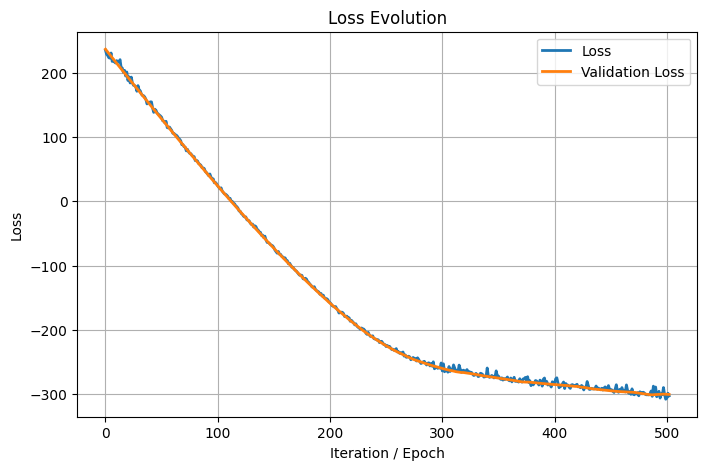

In [10]:
import matplotlib.pyplot as plt
loss_history = output['loss_history']
val_loss = output['val_history']


# Plot            
plt.figure(figsize=(8, 5))
plt.plot(loss_history, label="Loss", linewidth=2)
plt.plot(val_loss, label="Validation Loss", linewidth=2)
plt.xlabel("Iteration / Epoch")
plt.ylabel("Loss")
plt.title("Loss Evolution")
plt.legend()
plt.grid(True)
plt.show()

In [11]:
print(len(output['mu']), sum(p.numel() for p in model.parameters() if p.requires_grad))
print(output['mu'])

150 150
tensor([-9.4635e+00,  1.3712e+00,  1.2630e+00,  1.3049e+00,  1.2778e+00,
         1.8273e+00,  1.5809e+00,  1.2335e+00,  2.6662e+00,  1.6411e+00,
         1.6411e+00,  1.6411e+00, -9.2195e+00,  1.1520e+00,  1.1838e+00,
         1.1884e+00,  1.2699e+00,  1.6870e+00,  1.2179e+00,  9.1385e-01,
         2.4663e+00,  1.6411e+00,  1.6411e+00,  1.6411e+00, -1.7863e-02,
         1.9539e-02,  1.0694e-02, -4.7509e-02,  8.9193e-02, -1.2739e-01,
         7.0177e-02, -6.7094e-02,  5.0259e-02, -2.5456e-02,  6.1112e-02,
         1.0231e-01,  3.5794e-01,  3.6391e-01,  2.9726e-01,  2.2050e-01,
         1.7649e-01, -4.8625e-02, -2.3269e-01, -6.3180e-02, -2.0735e-01,
         2.2266e-01,  4.6761e-01,  3.2416e-01,  4.7585e-01,  2.1532e-01,
         1.0162e-01,  1.8120e-01,  5.6666e-01,  2.8064e-01, -1.3195e-01,
        -5.1817e-02,  1.2269e-01,  7.5772e-02, -3.7831e-02,  1.5637e-01,
         1.2886e-01,  1.2050e-01,  5.6904e-02, -2.4117e-02,  3.6227e-02,
        -9.6469e-03, -7.2837e-02, -8.7232e-

In [12]:
import torch

def flat_params(model):
    return torch.cat([p.detach().flatten().cpu() for p in model.parameters()])

# snapshot BEFORE
before = flat_params(model).clone()

model.bayesian_param_set(output, update_buffers=False)
# snapshot AFTER
after = flat_params(model)

max_abs_change = (after - before).abs().max().item()
print(f"Max |Δ| across all parameters: {max_abs_change:.3e}")



Max |Δ| across all parameters: 0.000e+00


In [13]:
# pretrain the marginal transformations
#_ = model.pretrain_transformation_layer(dataloader_train, iterations=1000, max_batches_per_iter=False, penalty_splines_params=penalty_splines_params)

In [14]:
# train the joint model
#_ = model.train(train_dataloader=dataloader_train, validate_dataloader=dataloader_validate, iterations=1000, optimizer="LBFGS",
#                penalty_splines_params=penalty_splines_params, adaptive_lasso_weights_matrix=adaptive_lasso_weights_matrix, penalty_lasso_conditional_independence=penalty_lasso_conditional_independence, 
#                max_batches_per_iter=False)

### 4. Compare to Benchmarks

We compare the learned GTM to a Gaussian Approximation and the Oracle Model. We expect the GTM to lie between these two in terms of approximation the true underlying distribution.
We measure this by means of the Kullback Leibler Divergence which we approximate on the test set which is equivalent to the log likelihood ratio between the true distribution and an approximation of it..

In [15]:
log_likelihood_train_gtm = model.log_likelihood(simulated_data_train)
log_likelihood_validate_gtm = model.log_likelihood(simulated_data_validate)
log_likelihood_test_gtm = model.log_likelihood(simulated_data_test)

In [16]:
# estimate the Multivariate Normal Distribution as Model
mean_mvn_model = simulated_data_train.mean(0)
cov_mvn_model = simulated_data_train.T.cov()
mvn_model = torch.distributions.MultivariateNormal(loc=mean_mvn_model, covariance_matrix=cov_mvn_model)
log_likelihood_train_gaussian = mvn_model.log_prob(simulated_data_train)
log_likelihood_validate_gaussian = mvn_model.log_prob(simulated_data_validate)
log_likelihood_test_gaussian = mvn_model.log_prob(simulated_data_test)


In [17]:
print("KLD GTM      Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gtm).item(),4) )
print("KLD Gaussian Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gaussian).item(),4) )
print("KLD Copula   Train Data: ",np.round(torch.mean(loglik_true_train - loglik_true_est_train).item(),4) )

print("KLD GTM      Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gtm).item(),4) )
print("KLD Gaussian Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gaussian).item(),4) )
print("KLD Copula   Test  Data: ",np.round(torch.mean(loglik_true_test - loglik_true_est_test).item(),4) )

KLD GTM      Train Data:  0.8182
KLD Gaussian Train Data:  0.0793
KLD Copula   Train Data:  -0.0007
KLD GTM      Test  Data:  0.8506
KLD Gaussian Test  Data:  0.1112
KLD Copula   Test  Data:  0.0025


### 5. Evaluate and Plot GTM Results

We evaluate the model further by showing how to generate synthetic samples, plot the conditional correlation patterns as well as the model splines.

Note that to generate synthetic samples the inverse of the trainsformation layer needs to be approximated  with the method `approximate_transformation_inverse` once which is then stored for future sampling. 

In [18]:
model.approximate_transformation_inverse()
synthetic_samples = model.sample(10000)

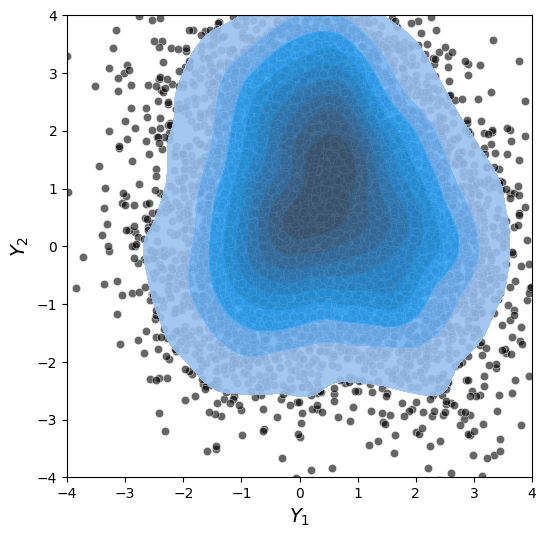

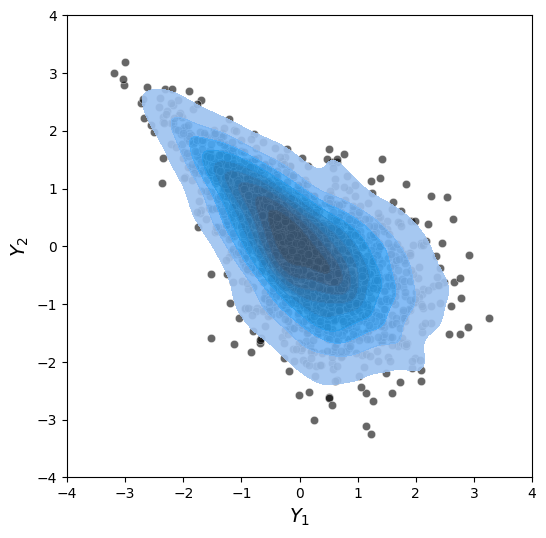

In [19]:
model.plot_densities(synthetic_samples, x_lim=[-4,4], y_lim=[-4,4])
model.plot_densities(simulated_data_train, x_lim=[-4,4], y_lim=[-4,4])

The varying pseudo conditional correlation matrix values can be computed for any synthetic samples using `compute_pseudo_conditional_correlation_matrix` or can directly be plotted using `plot_conditional_dependence_structure`.
The pseudo conditional correlation matrix is the standardised precision matrix so that off diagonal elements are the pseudo conditional correlations between the respective dimensions.

In [20]:
pseudo_conditional_correlation_matrix = model.compute_pseudo_conditional_correlation_matrix(synthetic_samples)

/Users/franciscocapunay/miniforge3/envs/gtm-magic-env-3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/franciscocapunay/miniforge3/envs/gtm-magic-env-3.11/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


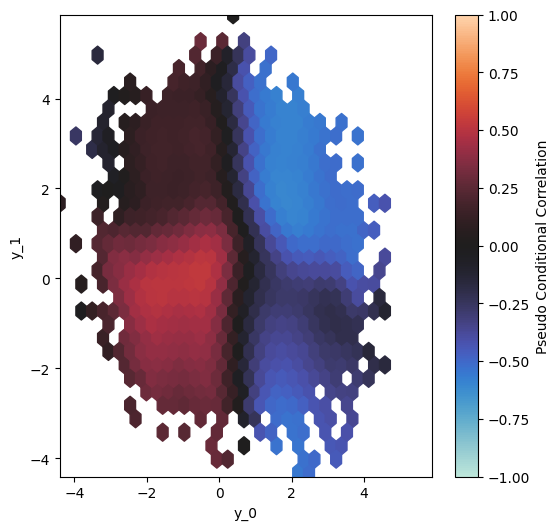

In [21]:
model.plot_conditional_dependence_structure(data=synthetic_samples)

One can also visualize the splines of each layer usign the function `plot_splines`. For the transformation layer we additionally include the dervaitive which is always positive due to the monotonically increasing constraint as well as the inverse which should lie exactly on the spline to visually confirm that the inverse sampling path works.

/Users/franciscocapunay/Documents/AkademischeAusbildungLernunterlagen/UniversitaetGoettingen/Studiengänge/MasterAngewandteStatistik/4.Semester/MA/code/gtm/gtm/gtm_plots_analysis/plot_splines.py:113: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


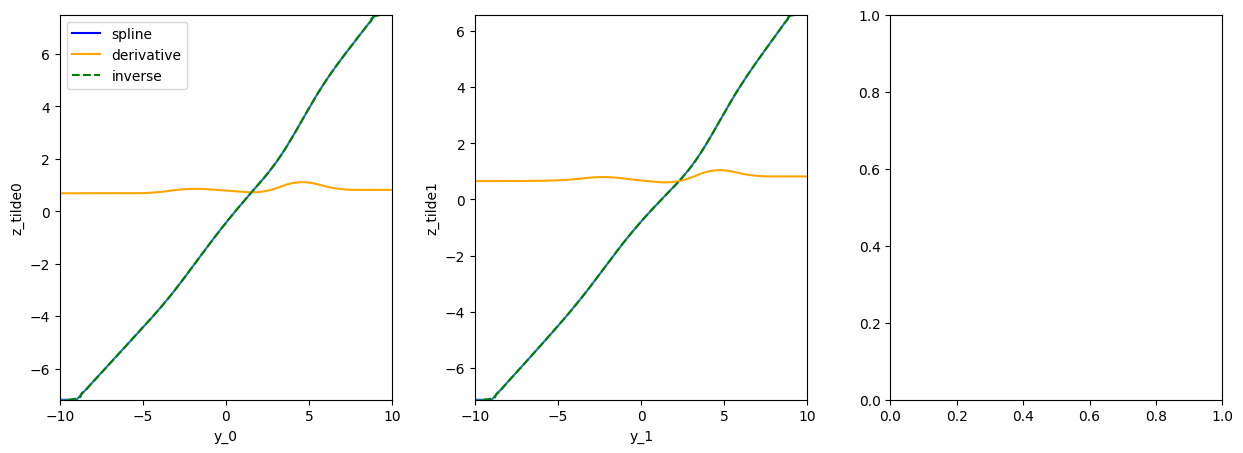

In [22]:
model.plot_splines(layer_type="transformation")

/Users/franciscocapunay/Documents/AkademischeAusbildungLernunterlagen/UniversitaetGoettingen/Studiengänge/MasterAngewandteStatistik/4.Semester/MA/code/gtm/gtm/gtm_plots_analysis/plot_splines.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


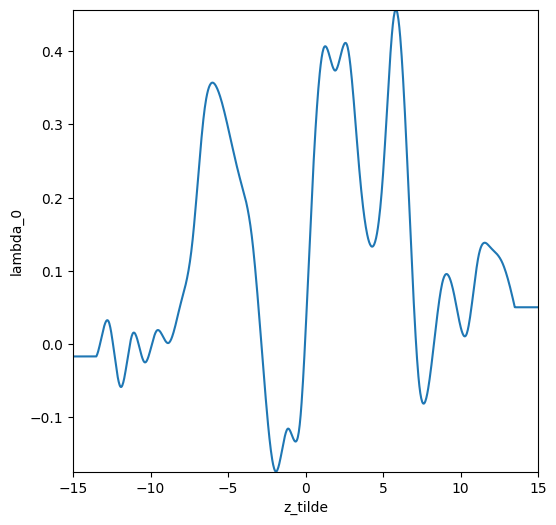

In [23]:
model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=0)

/Users/franciscocapunay/Documents/AkademischeAusbildungLernunterlagen/UniversitaetGoettingen/Studiengänge/MasterAngewandteStatistik/4.Semester/MA/code/gtm/gtm/gtm_plots_analysis/plot_splines.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


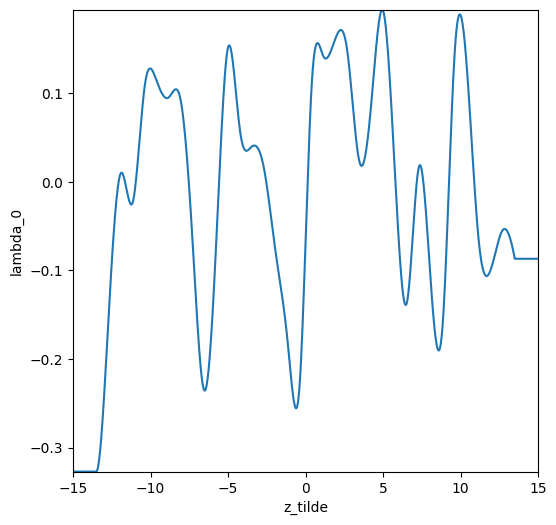

In [24]:
model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=1)

/Users/franciscocapunay/Documents/AkademischeAusbildungLernunterlagen/UniversitaetGoettingen/Studiengänge/MasterAngewandteStatistik/4.Semester/MA/code/gtm/gtm/gtm_plots_analysis/plot_splines.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


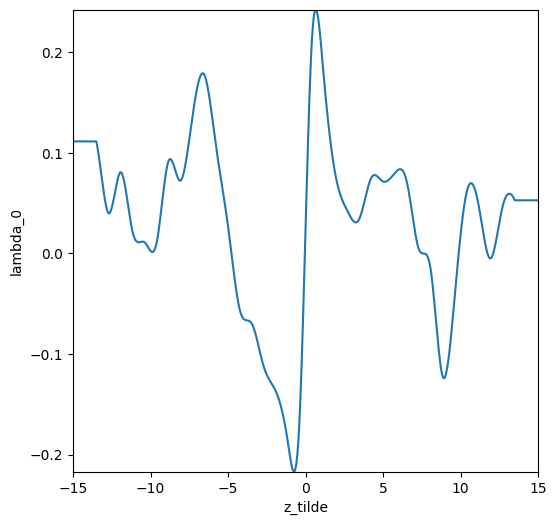

In [25]:
model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=2)